# 1 Environment Setup

## 1.1 Dependent Packages

In [2]:
!pip install -q keras
!pip install -q dgl
!pip install -q tensorboardX
!pip install -q torch_scatter -f https://data.pyg.org/whl/torch-2.2.1+cu118.html
!pip install -q statsmodels

In [2]:
import copy
import itertools
import json
import math
import os
import pickle
import re
import shutil
import sys
import time
import warnings
from typing import Dict, List  # typing module provides support for type hints

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric.nn as pyg_nn
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torch.nn import Linear as Lin, ReLU, Sequential as Seq
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

import geopandas as gpd

In [2]:
with open('./Data/Array_data/Y_mean_std_dict.pkl', 'rb') as f:
    Y_mean_std_dict = pickle.load(f)
# Y_test_std = Y_mean_std_dict['test'][1]
Y_mean_std_dict

{'train': [array([26.4177688]), array([18.13874099])],
 'validate': [array([24.91610469]), array([14.95305299])],
 'test': [array([28.63802161]), array([17.62297372])]}

In [18]:
print(torch.__version__)  
print(torch.cuda.is_available())  
print(torch.version.cuda)  
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))  

2.2.1+cu118
False
11.8


In [2]:
import tensorflow as tf

# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if GPU is available
print("GPU available:", tf.config.list_physical_devices('GPU'))

tf.test.is_built_with_cuda()


TensorFlow version: 2.15.0
GPU available: []


False

## 1.2 Load All Data

In [3]:
# Load torch data
Spatial_features_train_torch = torch.load('./Data/Torch_data/Spatial_features_train_torch.pt', weights_only=True)
Spatial_features_val_torch = torch.load('./Data/Torch_data/Spatial_features_val_torch.pt', weights_only=True)
Spatial_features_test_torch = torch.load('./Data/Torch_data/Spatial_features_test_torch.pt', weights_only=True)

Temporal_features_train_torch = torch.load('./Data/Torch_data/Temporal_features_train_torch.pt', weights_only=True)
Temporal_features_val_torch = torch.load('./Data/Torch_data/Temporal_features_val_torch.pt', weights_only=True)
Temporal_features_test_torch = torch.load('./Data/Torch_data/Temporal_features_test_torch.pt', weights_only=True)

External_features_train_torch = torch.load('./Data/Torch_data/External_features_train_torch.pt', weights_only=True)
External_features_val_torch = torch.load('./Data/Torch_data/External_features_val_torch.pt', weights_only=True)
External_features_test_torch = torch.load('./Data/Torch_data/External_features_test_torch.pt', weights_only=True)

Future_features_train_torch = torch.load('./Data/Torch_data/All_future_features_train_torch.pt', weights_only=True)
Future_features_val_torch = torch.load('./Data/Torch_data/All_future_features_val_torch.pt', weights_only=True)

Edge_index_torch = torch.load('./Data/Torch_data/Edge_index_torch_1.2.pt', weights_only=True)
Edge_index_train_torch = torch.load('./Data/Torch_data/Edge_index_train_torch_1.2.pt', weights_only=True)
Edge_index_val_torch = torch.load('./Data/Torch_data/Edge_index_val_torch_1.2.pt', weights_only=True)
Edge_index_test_torch = torch.load('./Data/Torch_data/Edge_index_test_torch_1.2.pt', weights_only=True)

Edge_weight_train_torch = torch.load('./Data/Torch_data/Edge_weight_train_torch_1.2.pt', weights_only=True)
Edge_weight_val_torch = torch.load('./Data/Torch_data/Edge_weight_val_torch_1.2.pt', weights_only=True)
Edge_weight_test_torch = torch.load('./Data/Torch_data/Edge_weight_test_torch_1.2.pt', weights_only=True)

Y_train_torch = torch.load('./Data/Torch_data/Y_train_torch.pt', weights_only=True)
Y_val_torch = torch.load('./Data/Torch_data/Y_val_torch.pt', weights_only=True)
Y_test_torch = torch.load('./Data/Torch_data/Y_test_torch.pt', weights_only=True)

In [4]:
print("train data: ", Spatial_features_train_torch.shape,Temporal_features_train_torch.shape, External_features_train_torch.shape, Future_features_train_torch.shape, Y_train_torch.shape, Edge_index_train_torch.shape, Edge_weight_train_torch.shape)
print("validate data: ", Spatial_features_val_torch.shape,Temporal_features_val_torch.shape, External_features_val_torch.shape, Future_features_val_torch.shape, Y_val_torch.shape, Edge_index_val_torch.shape, Edge_weight_val_torch.shape)
print("test data: ", Spatial_features_test_torch.shape,Temporal_features_test_torch.shape, External_features_test_torch.shape, Future_features_test_torch.shape, Y_test_torch.shape, Edge_index_test_torch.shape, Edge_weight_test_torch.shape)

train data:  torch.Size([6107, 44, 19]) torch.Size([6107, 44, 24, 8]) torch.Size([6107, 4]) torch.Size([6107, 44, 12, 11]) torch.Size([6107, 44, 12]) torch.Size([6107, 2, 414]) torch.Size([6107, 414, 1])
validate data:  torch.Size([872, 44, 19]) torch.Size([872, 44, 24, 8]) torch.Size([872, 4]) torch.Size([872, 44, 12, 11]) torch.Size([872, 44, 12]) torch.Size([872, 2, 414]) torch.Size([872, 414, 1])
test data:  torch.Size([1746, 44, 19]) torch.Size([1746, 44, 24, 8]) torch.Size([1746, 4]) torch.Size([1746, 44, 12, 11]) torch.Size([1746, 44, 12]) torch.Size([1746, 2, 414]) torch.Size([1746, 414, 1])


t_in = 24, t_out = 12

num_nodes = 44, num_edges = 512

num_features_s = 22, num_features_t = 8, num_features_e = 4, num_features_f = 12

spatial_features.shape: [num_timestamps, num_nodes, num_features_s]

temporal_features.shape: [num_timestamps, num_nodes, t_in, num_features_t]

future_features.shape: [num_timestamps, num_nodes, t_out, num_features_f]

external_features.shape: [num_timestamps, num_features_e]

edge_index.shape: [num_timestamps, 2, num_edges]

edge_weight.shape: [num_timestamps, 24, num_edges, 1]

labels.shape: [num_timestamps, num_nodes]

# 2 Model Structures

## 2.1 Baselines

### (1) MLP

In [27]:
class MLP(nn.Module):
    def __init__(self, num_feats, hyperparas):
        super(MLP, self).__init__()
        # Load model parameters
        num_feats_s, num_feats_t, num_feats_e, _ = num_feats
        fc_hid, dropout_prob = hyperparas
        t_in, t_out = 24, 12
        self.input_size = num_feats_s + t_in * num_feats_t +  num_feats_e
        self.hidden_size = fc_hid
        self.dropout_prob = dropout_prob 

        fcList = []
        reluList = []
        dropoutList = []
        for index in range(len(self.hidden_size)):
            if index != 0:
                self.input_size = self.hidden_size[index - 1]
            fc = nn.Linear(self.input_size, self.hidden_size[index])
            # Setting property names dynamically
            setattr(self, f'fc{index}', fc)
            fcList.append(fc)
            relu = nn.ReLU()
            setattr(self, f'relu{index}', relu)
            reluList.append(relu)
            dropout = nn.Dropout(self.dropout_prob)
            setattr(self, f'dropout{index}', dropout)
            dropoutList.append(dropout)

        self.last_fc = nn.Linear(self.hidden_size[-1], t_out)
        self.fcList = nn.ModuleList(fcList)
        self.reluList = nn.ModuleList(reluList)
        self.dropoutList = nn.ModuleList(dropoutList)
    
    def forward(self, multi_data):
        _, _, spatial_X, temporal_X, _, external_X = multi_data
        num_nodes = spatial_X.shape[1]
        # (num_timestamps, num_nodes, t_in, num_feats_t) --> (num_timestamps, num_nodes, t_in * num_feats_t)
        temporal_X = temporal_X.reshape(temporal_X.shape[0], temporal_X.shape[1], -1)
        external_X = external_X.unsqueeze(1).expand(-1, num_nodes, -1)
        all_X = torch.cat((temporal_X, spatial_X, external_X), dim=-1) 
        input = all_X
        for idx in range(len(self.fcList)):
            out = self.fcList[idx](input)
            out = self.reluList[idx](out)
            input = out
        output = self.last_fc(input) 
        return output

### (2) GRU

In [4]:
class GRU(nn.Module):
    def __init__(self, num_feats, hyperparas):
        super(GRU, self).__init__()

        num_feats_s, num_feats_t, num_feats_e, num_feats_f = num_feats
        gru_hid, dropout_prob = hyperparas
        self.gru_hid = gru_hid
        self.dropout_prob = dropout_prob
        # GRU layer for temporal features
        self.GRU_encoder = nn.GRU(num_feats_s + num_feats_t + num_feats_e, gru_hid, batch_first=True) # 19+8+4=31
        self.GRU_decoder = nn.GRU(1 + num_feats_f, gru_hid, batch_first=True)
        
        # Output layer for future predictions
        self.fc = nn.Linear(gru_hid, 1)  # Output single timestep prediction

    def forward(self, multi_data):

        edge_index, edge_weight, spatial_X, temporal_X, future_X, external_X = multi_data
        num_nodes, t_in, t_out = spatial_X.shape[1], temporal_X.shape[2], future_X.shape[2]
        #（num_timestamps, num_nodes, t_in) -->（batch_size, num_nodes, 1, 1) -->（batch_size * num_nodes, 1) 
        lastest_NO2 = temporal_X[:, :, -1, 0].reshape(-1, 1)
        
        #（num_timestamps, num_nodes, num_feats_s) -->（num_timestamps, num_nodes, spatial_emb) -->（num_timestamps, num_nodes, t_in, spatial_emb) -->（num_timestamps * num_nodes, t_in, spatial_emb) 
        spatial_X = spatial_X.unsqueeze(dim=-2).repeat_interleave(t_in, dim=-2)
        spatial_X = spatial_X.reshape(-1, spatial_X.shape[-2], spatial_X.shape[-1])

        #（num_timestamps, num_nodes, t_in, num_feats_t) -->（num_timestamps, num_nodes, t_in, temporal_emb) -->（num_timestamps * num_nodes, t_in, temporal_emb)
        temporal_X = temporal_X.reshape(-1, temporal_X.shape[-2], temporal_X.shape[-1])
        
        # (num_timestamps, num_features_e) --> (num_timestamps, global_emb) --> (num_timestamps, t_in, global_emb) --> (num_timestamps * num_nodes, t_in, global_emb)
        external_X = external_X.unsqueeze(dim=-2).repeat_interleave(t_in, dim=-2)
        external_X = external_X.repeat(num_nodes, 1, 1)
        
        # Concatenate temporal, spatial, and global features
        # (num_timestamps * num_nodes, t_in, num_features_s + num_features_t + num_features_e)
        all_X = torch.cat([spatial_X, temporal_X, external_X], dim=-1)

        all_X = F.dropout(all_X, p=self.dropout_prob, training=self.training)
        
        # Initialize hidden state for GRU
        # (lstm_layers, batch_size * num_nodes, lstm_hid)
        h_0 = torch.zeros(1, all_X.size(0), self.gru_hid).to(device)
        _, h_x = self.GRU_encoder(all_X, h_0)
        
        #（num_timestamps * num_nodes, t_out, 1)
        output_tout = torch.zeros((all_X.size(0), t_out, 1)).to(device) 
        # (num_timestamps, num_nodes, t_out, num_feats_f) --> (num_timestamps * num_nodes, t_out, num_feats_f) 
        future_X = future_X.reshape(-1, future_X.shape[-2], future_X.shape[-1]) 
        for i in range(t_out):
            Meteo_tout = future_X[:, i, :]
            # (num_timestamps * num_nodes, temporal_emb + num_feats_f) -->（num_timestamps * num_nodes, 1, temporal_emb + num_feats_f=8+11=19)
            inputs = torch.cat((lastest_NO2, Meteo_tout), dim=-1).unsqueeze(dim=1) 
            #（num_timestamps * num_nodes, 1, temporal_emb + num_feats_f) --> (num_timestamps * num_nodes, 1, gru_hid) -->（num_timestamps * num_nodes, gru_hid) 
            gru_X, h_x = self.GRU_decoder(inputs, h_x) 
            gru_X = gru_X.squeeze(dim=-2)
            output = self.fc(F.relu(gru_X))
            lastest_NO2 = output
            output_tout[:, i] = output

        output_tout.squeeze(dim=-1) 
        output_tout = output_tout.reshape(-1, num_nodes, t_out)
        
        return output_tout


### (3) GCN

In [4]:
import torch_geometric.nn as pyg_nn

class GCN(nn.Module):
    def __init__(self, num_feats, hyperparas):
        super(GCN, self).__init__()
        # Load model parameters
        num_feats_s, num_feats_t, num_feats_e, _ = num_feats
        gnn_hid, gnn_out, dropout_prob = hyperparas
        self.dropout_prob = dropout_prob
        self.t_in, self.t_out = 24, 12
        spatemp_emb = 64
        self.spatiotemporal_embedding = Seq(Lin(num_feats_s + num_feats_t * self.t_in, spatemp_emb), ReLU())  # 211 --> 64
        self.conv1 = pyg_nn.GCNConv(spatemp_emb, gnn_hid)  # 64 --> 32
        self.conv2 = pyg_nn.GCNConv(gnn_hid + spatemp_emb, gnn_out)  # 32 + 64 --> 32
        self.fc = nn.Linear(gnn_out + num_feats_e, self.t_out)  # 32+4 --> 12

    def forward(self, multi_data):
        edge_index, edge_weight, spatial_X, temporal_X, _, external_X = multi_data
        num_nodes = spatial_X.shape[1]
        
        # (num_timestamps, num_nodes, num_feats_s) --> (num_timestamps * num_nodes, num_feats_s) 
        spatial_X = spatial_X.reshape(-1, spatial_X.shape[-1])
        # (num_timestamps, num_nodes, t_in, num_feats_t) --> (num_timestamps, num_nodes, t_in * num_feats_t) --> (num_timestamps * num_nodes, t_in * num_feats_t)
        temporal_X = temporal_X.reshape(temporal_X.shape[0], temporal_X.shape[1], -1)
        temporal_X = temporal_X.reshape(-1, temporal_X.shape[-1])
        #（num_timestamps * num_nodes, num_feats_s + t_in * num_feats_t) --> （num_timestamps * num_nodes, spatemp_emb)
        spt_X = torch.cat([temporal_X, spatial_X], dim=-1)
        spt_X = self.spatiotemporal_embedding(spt_X)
        
        # Edge Information Processing
        # (num_timestamps, 2, num_edges) --> (num_timestamps, num_edges, 2) --> (num_edges, num_timestamps, 2) --> (2,  num_timestamps * num_edges)
        edge_index = edge_index.transpose(1, 2)
        # new num_nodes = num_timestamps * num_nodes for correct indexing
        for i in range(edge_index.size(0)):  
            edge_index[i, :] = torch.add(edge_index[i, :], i * num_nodes)
        edge_index = edge_index.transpose(0, 1).reshape(2, -1)
        # (num_timestamps, num_edges, 1) --> (num_timestamps * num_edges, 1)
        edge_weight = F.relu(edge_weight)
        edge_weight = edge_weight.reshape(-1, edge_weight.shape[-1]) 

        # (num_timestamps, num_feats_e) --> (num_timestamps, num_nodes, num_feats_e) 
        external_X = external_X.unsqueeze(1).expand(-1, num_nodes, -1)
        external_X = external_X.reshape(-1, external_X.shape[-1])
        
        #（num_timestamps * num_nodes, num_feats_s + t_in * num_feats_t) -->（num_timestamps * num_nodes, gnn_hid)
        gnn_X = F.relu(self.conv1(spt_X, edge_index, edge_weight=edge_weight)) 
        gnn_X = F.dropout(gnn_X, p=self.dropout_prob, training=self.training)
        # Residual connection (batch_size * t_in * num_nodes, num_feats_s + t_in * num_feats_t + gnn_hid) 
        gnn_X = torch.cat([spt_X, gnn_X], dim=-1)
        gnn_X = F.relu(self.conv2(gnn_X, edge_index, edge_weight=edge_weight))
        # （num_timestamps * num_nodes, gnn_out + num_feats_e) --> （num_timestamps * num_nodes, t_out)
        all_X = torch.cat([gnn_X, external_X], dim=-1)
        output = self.fc(all_X)
        #（num_timestamps * num_nodes, t_out) -->（num_timestamps, num_nodes, t_out)
        output = output.reshape(-1, num_nodes, self.t_out)
        
        return output

## 2.2 HighAir

Code reference: Xu, Jiahui, Ling Chen, Mingqi Lv, Chaoqun Zhan, Sanjian Chen, and Jian Chang. “HighAir: A Hierarchical Graph Neural Network-Based Air Quality Forecasting Method,” n.d.

https://github.com/Friger/HighAir


### (1) Spatial Modeling

In [ ]:
class GraphNN(torch.nn.Module):
    def __init__(self, num_feats_emb, num_edge_attr, gnn_out, global_emb): 
        super(GraphNN, self).__init__()
        self.node_mlp_1 = Seq(Lin(2 * num_feats_emb + num_edge_attr, gnn_out), 
                            ReLU(inplace=True))
        self.node_mlp_2 = Seq(Lin(num_feats_emb + gnn_out + global_emb, gnn_out),
                            ReLU(inplace=True))

    def forward(self, edge_index, edge_weight, spat_x, external_X):
        sta_idx, end_idx = edge_index 
        # （batch_size * 24 * num_edges, spatial_emb + temporal_emb) +（batch_size * 24 * num_edges, spatial_emb + temporal_emb) + (batch_size * 24 * num_edges, 2) --> (batch_size * 24 * num_edges, 2 * node_h + edge_h) 
        out = torch.cat([spat_x[sta_idx], spat_x[end_idx], edge_weight], dim=1) 
        # (batch_size * 24 * num_edges, 2 * node_h + edge_h) -->  (batch_size * 24 * num_edges, gnn_out)
        out = self.node_mlp_1(out)  
        # (batch_size * 24 * num_edges, gnn_out) --> (batch_size * 24 * num_nodes, gnn_out)
        out = scatter_mean(out, end_idx, dim=0, dim_size=spat_x.size(0))
        # (batch_size * 24 * num_nodes, spatial_emb + temporal_emb + gnn_out + wea_em*2) 
        out = torch.cat([spat_x, out, external_X], dim=1)  
        # (batch_size * 24 * num_nodes, gnn_out) 
        out = self.node_mlp_2(out)
        return out  

In [5]:
class GraphNN(torch.nn.Module):
    def __init__(self, num_feats_emb, num_edge_attr, gnn_out, global_emb): 
        super(GraphNN, self).__init__()
        self.node_mlp_1 = Seq(Lin(2 * num_feats_emb + num_edge_attr, gnn_out), 
                            ReLU(inplace=True))
        self.node_mlp_2 = Seq(Lin(num_feats_emb + gnn_out + global_emb, gnn_out),
                            ReLU(inplace=True))

    def forward(self, edge_index, edge_weight, spat_x, external_X):
        sta_idx, end_idx = edge_index 
        # Stitching together edge start node features, end node features, and edge features as input for message passing
        out = torch.cat([spat_x[sta_idx], spat_x[end_idx], edge_weight], dim=1) 
        # (batch_size * 24 * num_edges, 2 * node_h + edge_h) -->  (batch_size * 24 * num_edges, gnn_out)
        out = self.node_mlp_1(out)  
        # Average aggregation of features of all edges pointing to the same termination node (col) based on the index of the termination node of the edge (col)
        out = scatter_mean(out, end_idx, dim=0, dim_size=spat_x.size(0))
        # The raw node features, aggregated edge features and global features are stitched together as input for the next step
        out = torch.cat([spat_x, out, external_X], dim=1) 
        out = self.node_mlp_2(out)
        # (batch_size * 24 * num_nodes, gnn_out) 
        return out  

### (2) Temporal Modeling

Encoder: converts the input sequence into a fixed-size context vector that captures the semantic information of the input 

Decoder: generates the target sequence step-by-step based on the context vector, with each time step dependent on the output and state of the previous time step

In [6]:
class RNNEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)

    def forward(self, x, h0, c0):
        # (batch_size * num_nodes, 24, gnn_out), (lstm_layers, batch_size * num_nodes, lstm_hid), (lstm_layers, batch_size * num_nodes, lstm_hid)
        # Set initial hidden and cell states
        _, (h_n, c_n) = self.lstm(x, (h0, c0))  
        # Decode the hidden state of the last time step
        return h_n, c_n

class RNNDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
        self.lin = nn.Linear(hidden_size, 1) 
        self.relu = nn.ReLU()

    def forward(self, x, h_0, c_0):
        # x : （batch_size * num_nodes, 1, temporal_emb + num_features_f) 
        out, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        # (batch_size, seq_length, hidden_size) --> (batch_size * num_nodes, 1, lstm_hid)
        out = self.relu(out)
        out = self.lin(out)  
        return out, h_n, c_n

### (3) Fusion Models

In [8]:
class HighAir(nn.Module):
    def __init__(self, num_feats, hyperparas):
        super(HighAir, self).__init__()
        # Load model parameters
        num_feats_s, num_feats_t, num_feats_e, num_feat_f, num_edge_attr = num_feats
        gnn_out, lstm_hid, lstm_layers, temporal_emb, spatial_emb, global_emb = hyperparas
        self.lstm_hid = lstm_hid
        self.lstm_layers = lstm_layers
        self.spatial_embedding = Seq(Lin(num_feats_s, spatial_emb), ReLU())  
        self.temporal_embedding = Seq(Lin(num_feats_t, temporal_emb), ReLU())  
        self.global_embedding = Seq(Lin(num_feats_e, global_emb), ReLU())
        self.GNN = GraphNN(temporal_emb + spatial_emb, num_edge_attr, gnn_out, global_emb)
        self.LSTM_encoder = RNNEncoder(input_size=gnn_out,
                                hidden_size=lstm_hid,
                                num_layers=lstm_layers)
        self.decoder_embedding = Seq(Lin(1, temporal_emb), ReLU()) 
        self.LSTM_decoder = RNNDecoder(input_size= temporal_emb + num_feat_f,
                                hidden_size=lstm_hid,
                                num_layers=lstm_layers)

    def forward(self, multi_data):
        
        edge_index, edge_weight, spatial_X, temporal_X, future_X, external_X = multi_data
        num_nodes, t_in, t_out = spatial_X.shape[1], temporal_X.shape[2], future_X.shape[2]
        #（batch_size, num_nodes, t_in) -->（batch_size, num_nodes, 1, 1) -->（batch_size * num_nodes, 1) 
        lastest_NO2 = temporal_X[:, :, -1, 0].reshape(-1, 1) 
        
        # Spatiotemporal Information Processing
        #（batch_size, num_nodes, t_in, num_feats_t) -->（batch_size, num_nodes, t_in, temporal_emb)
        temporal_X = self.temporal_embedding(temporal_X)

        #（batch_size, num_nodes, num_feats_s) -->（batch_size, num_nodes, spatial_emb) -->（batch_size, num_nodes, t_in, spatial_emb)
        spatial_X = self.spatial_embedding(spatial_X)
        spatial_X = spatial_X.unsqueeze(dim=-2).repeat_interleave(t_in, dim=-2)

        #（batch_size, num_nodes, t_in, spatial_emb + temporal_emb) -->（batch_size * t_in, num_nodes, spatial_emb + temporal_emb) -->（batch_size * t_in * num_nodes, spatial_emb + temporal_emb)
        spt_X = torch.cat([temporal_X, spatial_X], dim=-1)
        spt_X = spt_X.transpose(1, 2)
        spt_X = spt_X.reshape(-1, spt_X.shape[-2], spt_X.shape[-1])
        spt_X = spt_X.reshape(-1, spt_X.shape[-1])  

        # Edge Information Processing
        # (batch_size, 2, num_edges) --> (batch_size, num_edges, 2) --> (batch_size * t_in, num_edges, 2) --> (num_edges, batch_size * t_in, 2) --> (2,  batch_size * t_in * num_edges)
        edge_index = edge_index.transpose(1, 2).repeat(t_in, 1, 1)
        for i in range(edge_index.size(0)):  
            edge_index[i, :] = torch.add(edge_index[i, :], i * num_nodes)
        edge_index = edge_index.transpose(0, 1).reshape(2, -1)

        # (batch_size, num_edges, 1) --> (batch_size, t_in, num_edges, 1) --> (batch_size * t_in, num_edges, 1) --> (batch_size * t_in * num_edges, 1)
        edge_weight = edge_weight.unsqueeze(dim=2).repeat_interleave(t_in, dim=2)
        edge_weight = edge_weight.reshape(-1, edge_weight.shape[-2], edge_weight.shape[-1])
        edge_weight = edge_weight.reshape(-1, edge_weight.shape[-1]) 

        # Global Information Processing
        # (batch_size, num_features_e) --> (batch_size, global_emb) --> (batch_size, t_in, global_emb) --> (batch_size * t_in, global_emb) --> (batch_size * t_in * num_nodes, global_emb)
        external_X = self.global_embedding(external_X)  
        external_X = external_X.unsqueeze(dim=-2).repeat_interleave(t_in, dim=-2)
        external_X = external_X.reshape(-1, external_X.shape[-1]).repeat(num_nodes, 1)

        # Graph convolution
        # (batch_size * t_in * num_nodes, spatial_emb + temporal_emb) --> (batch_size * t_in * num_nodes, gnn_out) --> (batch_size, t_in, num_nodes, gnn_out) --> (batch_size, num_nodes, t_in, gnn_out) --> (batch_size * num_nodes, t_in, gnn_out)
        gnn_X = self.GNN(edge_index, edge_weight, spt_X, external_X) 
        gnn_X = gnn_X.reshape(-1, t_in, num_nodes, gnn_X.shape[-1]).transpose(1, 2)
        gnn_X = gnn_X.reshape(-1, t_in, gnn_X.shape[-1])

        # LSTM encoder
        # (lstm_layers, batch_size * num_nodes, lstm_hid)
        h0 = torch.randn(self.lstm_layers, gnn_X.size(0), self.lstm_hid).to(device)  
        c0 = torch.randn(self.lstm_layers, gnn_X.size(0), self.lstm_hid).to(device)  
        # (batch_size * num_nodes, t_in, gnn_out), (lstm_layers, batch_size * num_nodes, lstm_hid), (lstm_layers, batch_size * num_nodes, lstm_hid) --> h_x, c_x (lstm_layers, batch_size * num_nodes, lstm_hid) （合并掉了24）
        h_x, c_x = self.LSTM_encoder(gnn_X, h0, c0)

        # LSTM-decoder
        #（batch_size * num_nodes, t_out, 1)
        outputs = torch.zeros((gnn_X.size(0), t_out, 1)).to(device)  

        # (batch_size, num_nodes, t_out, num_features) --> (batch_size * num_nodes, t_out, num_features) 
        future_X = future_X.reshape(-1, future_X.shape[-2], future_X.shape[-1]) 

        for i in range(t_out): 
            #（batch_size * num_nodes, 1) -->（batch_size * num_nodes, temporal_emb)
            NO2_emb = self.decoder_embedding(lastest_NO2)  
            Meteo_tout = future_X[:, i, :]
            # (batch_size * num_nodes, temporal_emb + num_features_f) -->（batch_size * num_nodes, 1, temporal_emb + num_features_f)
            inputs = torch.cat((NO2_emb, Meteo_tout), dim=-1).unsqueeze(dim=1) 
            #（batch_size * num_nodes, 1, temporal_emb + 1) -->（batch_size * num_nodes, 1, 1) -->（batch_size * num_nodes, 1) 
            output, h_x, c_x = self.LSTM_decoder(inputs, h_x, c_x) 
            output = output.reshape(-1, 1)
            lastest_NO2 = output  
            outputs[:, i] = output  
        #（batch_size * num_nodes, t_out, 1) -->（batch_size, num_nodes, t_out) 
        outputs = outputs.reshape(-1, num_nodes, t_out)  

        return outputs

## 2.3 REGAL (Road Emission GAT-LSTM)

### (1) Spatial Modeling

In [32]:
import torch_geometric.nn as pyg_nn
class GAT(torch.nn.Module):
    def __init__(self, spt_emb, gat_hid, gat_out, dropout_prob):
        super(GAT, self).__init__()
        self.dropout_prob = dropout_prob
        self.in_head = 8
        self.out_head = 1
        self.conv1 = pyg_nn.GATConv(spt_emb, gat_hid, heads=self.in_head, edge_dim=1) 
        self.conv2 = pyg_nn.GATConv(gat_hid*self.in_head+spt_emb, gat_out, heads=self.out_head, concat=False, edge_dim=1) 

    def forward(self, edge_index, edge_weight, spt_x):
        gat_x = F.relu(self.conv1(spt_x, edge_index, edge_weight))
        gat_x = F.dropout(gat_x, p=self.dropout_prob, training=self.training)
        # Residual connection (batch_size * t_in * num_nodes, spatial_emb + temporal_emb + gat_hid*self.in_head) 
        gat_x = torch.cat([spt_x, gat_x], dim=-1)
        output = F.relu(self.conv2(gat_x, edge_index, edge_weight))
        return output

### (2) Temporal Modeling

In [29]:
class RNNEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True) 

    def forward(self, x, h0, c0):
        # (batch_size * num_nodes, 24, gnn_out), (lstm_layers, batch_size * num_nodes, lstm_hid), (lstm_layers, batch_size * num_nodes, lstm_hid)
        # Set initial hidden and cell states
        _, (h_n, c_n) = self.lstm(x, (h0, c0))  
        # out: tensor of shape (batch_size, seq_length, hidden_size)  i.e. (batch_size * num_nodes, 24, lstm_hid)
        return h_n, c_n

class RNNDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)

    def forward(self, x, h_0, c_0):
        # x : （batch_size * num_nodes, 1, temporal_emb + num_features_f) 
        out, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        return out, h_n, c_n

### (3) Fusion Models

In [30]:
class REGAL(nn.Module):
    def __init__(self, num_feats, hyperparas):
        super(REGAL, self).__init__()
        # Load model parameters
        num_feats_s, num_feats_t, num_feats_e, num_feat_f = num_feats
        gat_hid, gat_out, dropout_prob, lstm_hid, lstm_layers, temporal_emb, spatial_emb, global_emb = hyperparas
        self.lstm_hid = lstm_hid
        self.lstm_layers = lstm_layers
        self.spatial_embedding = Seq(Lin(num_feats_s, spatial_emb), ReLU())  
        self.temporal_embedding = Seq(Lin(num_feats_t, temporal_emb), ReLU())  
        self.global_embedding = Seq(Lin(num_feats_e, global_emb), ReLU())
        self.GAT = GAT(spatial_emb + temporal_emb, gat_hid, gat_out, dropout_prob)
        self.LSTM_encoder = RNNEncoder(input_size=gat_out+global_emb, 
                                hidden_size=lstm_hid,
                                num_layers=lstm_layers)
        self.decoder_embedding = Seq(Lin(1, temporal_emb), ReLU()) 
        self.LSTM_decoder = RNNDecoder(input_size= temporal_emb + num_feat_f,
                                hidden_size=lstm_hid,
                                num_layers=lstm_layers)
        self.output_layer = nn.Sequential(nn.ReLU(), nn.Linear(lstm_hid, 1))  

    def forward(self, multi_data):
        
        edge_index, edge_weight, spatial_X, temporal_X, future_X, external_X = multi_data
        num_nodes, t_in, t_out = spatial_X.shape[1], temporal_X.shape[2], future_X.shape[2]
        #（batch_size, num_nodes, t_in) -->（batch_size, num_nodes, 1, 1) -->（batch_size * num_nodes, 1) 
        lastest_NO2 = temporal_X[:, :, -1, 0].reshape(-1, 1) 
        
        # Spatiotemporal Information Processing
        #（batch_size, num_nodes, t_in, num_feats_t) -->（batch_size, num_nodes, t_in, temporal_emb)
        temporal_X = self.temporal_embedding(temporal_X)

        #（batch_size, num_nodes, num_feats_s) -->（batch_size, num_nodes, spatial_emb) -->（batch_size, num_nodes, t_in, spatial_emb)
        spatial_X = self.spatial_embedding(spatial_X)
        spatial_X = spatial_X.unsqueeze(dim=-2).repeat_interleave(t_in, dim=-2)

        #（batch_size, num_nodes, t_in, spatial_emb + temporal_emb) -->（batch_size * t_in, num_nodes, spatial_emb + temporal_emb) -->（batch_size * t_in * num_nodes, spatial_emb + temporal_emb)
        spt_X = torch.cat([temporal_X, spatial_X], dim=-1)
        spt_X = spt_X.transpose(1, 2)
        spt_X = spt_X.reshape(-1, spt_X.shape[-2], spt_X.shape[-1])
        spt_X = spt_X.reshape(-1, spt_X.shape[-1])  

        # Edge Information Processing
        # (batch_size, 2, num_edges) --> (batch_size, num_edges, 2) --> (batch_size * t_in, num_edges, 2) --> (num_edges, batch_size * t_in, 2) --> (2,  batch_size * t_in * num_edges)
        edge_index = edge_index.transpose(1, 2).repeat(t_in, 1, 1)
        for i in range(edge_index.size(0)):  
            edge_index[i, :] = torch.add(edge_index[i, :], i * num_nodes)
        edge_index = edge_index.transpose(0, 1).reshape(2, -1)  

        # (batch_size, num_edges, 1) --> (batch_size, t_in, num_edges, 1) --> (batch_size * t_in, num_edges, 1) --> (batch_size * t_in * num_edges, 1)
        edge_weight = F.relu(edge_weight)
        edge_weight = edge_weight.unsqueeze(dim=2).repeat_interleave(t_in, dim=2)
        edge_weight = edge_weight.reshape(-1, edge_weight.shape[-2], edge_weight.shape[-1])
        edge_weight = edge_weight.reshape(-1, edge_weight.shape[-1]) 
        
        # Global Information Processing
        # (batch_size, num_features_e) --> (batch_size, global_emb) --> (batch_size, t_in, global_emb) --> (batch_size * t_in, global_emb) --> (batch_size * t_in * num_nodes, global_emb)
        external_X = self.global_embedding(external_X)  
        external_X = external_X.unsqueeze(dim=-2).repeat_interleave(t_in, dim=-2)
        external_X = external_X.reshape(-1, external_X.shape[-1]).repeat(num_nodes, 1)
        
        # Graph convolution
        # (batch_size * t_in * num_nodes, spatial_emb + temporal_emb) --> (batch_size * t_in * num_nodes, gat_out) --> (batch_size * t_in * num_nodes, gat_out + global_emb) 
        gat_X = self.GAT(edge_index, edge_weight, spt_X)
        gat_X = torch.cat([gat_X, external_X], dim=1)
        #  (batch_size * t_in * num_nodes, gat_out + global_emb) --> (batch_size, t_in, num_nodes, gat_out + global_emb) --> (batch_size, num_nodes, t_in, gat_out + global_emb) --> (batch_size * num_nodes, t_in, gat_out + global_emb)
        gat_X = gat_X.reshape(-1, t_in, num_nodes, gat_X.shape[-1]).transpose(1, 2)
        gat_X = gat_X.reshape(-1, t_in, gat_X.shape[-1])

        # LSTM encoder
        # (lstm_layers, batch_size * num_nodes, lstm_hid)
        h0 = torch.randn(self.lstm_layers, gat_X.size(0), self.lstm_hid).to(device)  
        c0 = torch.randn(self.lstm_layers, gat_X.size(0), self.lstm_hid).to(device)  
        # (batch_size * num_nodes, t_in, gat_out + global_emb), (lstm_layers, batch_size * num_nodes, lstm_hid), (lstm_layers, batch_size * num_nodes, lstm_hid) --> h_x, c_x (lstm_layers, batch_size * num_nodes, lstm_hid) （合并掉了24）
        h_x, c_x = self.LSTM_encoder(gat_X, h0, c0)

        # LSTM-decoder
        #（batch_size * num_nodes, t_out, 1)
        output_tout = torch.zeros((gat_X.size(0), t_out, 1)).to(device)  

        # (batch_size, num_nodes, t_out, num_features) --> (batch_size * num_nodes, t_out, num_features) 
        future_X = future_X.reshape(-1, future_X.shape[-2], future_X.shape[-1]) 

        for i in range(t_out): 
            #（batch_size * num_nodes, 1) -->（batch_size * num_nodes, temporal_emb)
            NO2_emb = self.decoder_embedding(lastest_NO2)  
            Meteo_tout = future_X[:, i, :]
            # (batch_size * num_nodes, temporal_emb + num_features_f) -->（batch_size * num_nodes, 1, temporal_emb + num_features_f)
            inputs = torch.cat((NO2_emb, Meteo_tout), dim=-1).unsqueeze(dim=1) 
            #（batch_size * num_nodes, 1, temporal_emb + num_features_f) --> (batch_size * num_nodes, 1, lstm_hid) -->（batch_size * num_nodes, lstm_hid)
            lstm_X, h_x, c_x = self.LSTM_decoder(inputs, h_x, c_x) 
            lstm_X = lstm_X.squeeze(dim=-2)
            output = self.output_layer(lstm_X) 
            lastest_NO2 = output  
            output_tout[:, i] = output  

        #（batch_size * num_nodes, t_out, 1) -->（batch_size * num_nodes, t_out) -->（batch_size, num_nodes, t_out)
        output_tout.squeeze(dim=-1) 
        output_tout = output_tout.reshape(-1, num_nodes, t_out)

        return output_tout

# 3 Train and Test

## 3.1 Parameter Set-up

In [7]:
# Global settings
if torch.cuda.is_available():
    device = 'cuda:0'
else: device = 'cpu'

num_workers = 4

## 3.2 Load Dataset

In [17]:
from torch.utils.data import Dataset, DataLoader

class MultiDataset(Dataset):
    def __init__(self, phase: str, lambda_: float, feat_set="All"):
        """
        Load all data
        """
        self.edge_index = torch.load(f'./Data/Torch_data/Edge_index_{phase}_torch_{lambda_}.pt')
        self.edge_weight = torch.load(f'./Data/Torch_data/Edge_weight_{phase}_torch_{lambda_}.pt')
        self.spatial_features = torch.load(f'./Data/Torch_data/Spatial_features_{phase}_torch.pt')
        self.temporal_features = torch.load(f'./Data/Torch_data/Temporal_features_{phase}_torch.pt')
        self.future_features = torch.load(f'./Data/Torch_data/All_future_features_{phase}_torch.pt')
        self.external_features = torch.load(f'./Data/Torch_data/External_features_{phase}_torch.pt')
        self.ground_truth = torch.load(f'./Data/Torch_data/Y_{phase}_torch.pt')
        
        if feat_set == "All":
            pass

        elif ablation_feat_dict[feat_set][0] == "spatial":
            slice_= ablation_feat_dict[feat_set][1]
            if isinstance(slice_, list):
                self.spatial_features = torch.cat([self.spatial_features[:, :, slice_[0]], self.spatial_features[:, :, slice_[1]]], dim=-1)
            else:
                self.spatial_features = self.spatial_features[:, :, slice_]

        elif ablation_feat_dict[feat_set][0] == "temporal":
            slice_ = ablation_feat_dict[feat_set][1]
            self.temporal_features = self.temporal_features[:, :, :, slice_]
            if len(self.temporal_features.shape) < 4:
                self.temporal_features = self.temporal_features.unsqueeze(dim=-1) 

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.ground_truth)

    def __getitem__(self, idx):
            """
            Args: idx (int): the index of the sample (num_timestamps) to retrieve
            """            
            edge_index = self.edge_index[idx]
            edge_weight = self.edge_weight[idx]
            spatial_X = self.spatial_features[idx]
            temporal_X = self.temporal_features[idx]
            external_X = self.external_features[idx]
            future_X = self.future_features[idx]
            truth_Y = self.ground_truth[idx]

            Dataset = [edge_index, edge_weight, spatial_X, temporal_X, future_X, external_X, truth_Y]

            return Dataset
    
def Create_dataloader(graph_lambda="1.2", batch_size=64, num_workers=4, feat_set="All"):

    dataset_train = MultiDataset(phase='train', lambda_=graph_lambda, feat_set=feat_set)
    dataset_val = MultiDataset(phase='val', lambda_=graph_lambda, feat_set=feat_set)
    dataset_test = MultiDataset(phase='test', lambda_=graph_lambda, feat_set=feat_set)

    dataloaders = {
        "train": DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers),
        "validate": DataLoader(dataset_val, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers),
        "test": DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)
        }
    
    return dataloaders

In [9]:
dataset_train = torch.load(f'./Data/Torch_data/dataset_train_1.2.pt')
dataset_val = torch.load(f'./Data/Torch_data/dataset_val_1.2.pt')
dataset_test = torch.load(f'./Data/Torch_data/dataset_test_1.2.pt')
batch_size, num_workers = 64, 0
# Create data loaders
dataloaders = {
    "train": DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers),  # collate_fn=collate_fn
    "validate": DataLoader(dataset_val, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers),
    "test": DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)
    }

# Verify DataLoader functionality
for phase in ["train", "validate", "test"]:
    print(f"Phase: {phase}")
    for batch in dataloaders[phase]:
        Edge_index_batch, Edge_weight_batch, spatial_X_batch, temporal_X_batch, future_X_batch, external_X_batch, Truth_Y_batch = batch
        print("Batched edge index shape:", Edge_index_batch.shape)
        print("Batched edge weight shape:", Edge_weight_batch.shape)
        print("Batched spatial features shape:", spatial_X_batch.shape)
        print("Batched temporal features shape:", temporal_X_batch.shape)
        print("Batched future features shape:", future_X_batch.shape)
        print("Batched external features shape:", external_X_batch.shape)
        print("Batched ground truth shape:", Truth_Y_batch.shape)
        break  # Only print the first batch's information

/tmp/ipykernel_12171/3363773701.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset_train = torch.load(f'./Data/Torch_data/dataset_train_1.2.pt')
/tmp/ipykernel_121

Phase: train
Batched edge index shape: torch.Size([64, 2, 414])
Batched edge weight shape: torch.Size([64, 414, 1])
Batched spatial features shape: torch.Size([64, 44, 19])
Batched temporal features shape: torch.Size([64, 44, 24, 8])
Batched future features shape: torch.Size([64, 44, 12, 11])
Batched external features shape: torch.Size([64, 4])
Batched ground truth shape: torch.Size([64, 44, 12])
Phase: validate
Batched edge index shape: torch.Size([64, 2, 414])
Batched edge weight shape: torch.Size([64, 414, 1])
Batched spatial features shape: torch.Size([64, 44, 19])
Batched temporal features shape: torch.Size([64, 44, 24, 8])
Batched future features shape: torch.Size([64, 44, 12, 11])
Batched external features shape: torch.Size([64, 4])
Batched ground truth shape: torch.Size([64, 44, 12])
Phase: test
Batched edge index shape: torch.Size([64, 2, 414])
Batched edge weight shape: torch.Size([64, 414, 1])
Batched spatial features shape: torch.Size([64, 44, 19])
Batched temporal features

## 3.3 Train Epochs

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

def model_evaluate(y_predictions: np.ndarray, y_truths: np.ndarray):
    # Ensure the predictions and truths have the same shape
    assert y_predictions.shape == y_truths.shape, \
        f'Predictions of shape {y_predictions.shape} while target of shape {y_truths.shape}.'
    
    # Initialize dictionary to store the results for each metric
    all_metrics = {'RMSE': [], 'MAE': [], 'PCC': []}

    # Define the time step ranges
    time_step_ranges = [range(0, 1), range(0, 4), range(4, 8), range(8, 12), range(0, 12)]

    for time_range in time_step_ranges:
        # Flatten the arrays for the current time range
        y_pred_interval = y_predictions[:, :, time_range].reshape(-1)
        y_truth_interval = y_truths[:, :, time_range].reshape(-1)

        # Calculate RMSE
        rmse = mean_squared_error(y_truth_interval, y_pred_interval) ** 0.5
        # Calculate MAE
        mae = mean_absolute_error(y_truth_interval, y_pred_interval)
        # Calculate PCC
        pcc, _ = pearsonr(y_pred_interval, y_truth_interval)

        # Append the results to the respective lists in the dictionary
        all_metrics['RMSE'].append(float(rmse))
        all_metrics['MAE'].append(float(mae))
        all_metrics['PCC'].append(float(pcc))

    # Delete these variables to free up memory and ensure that subsequent code does not use them again
    del y_predictions, y_truths

    return all_metrics

In [11]:
def train_model(model: nn.Module,
                data_loaders: Dict[str, DataLoader],
                loss_func: callable,
                optimizer,
                num_epochs: int,
                set_early_stop: str
                ):
    
    phases = ['train', 'validate', 'test']
    metric_name = ['RMSE', 'MAE', 'PCC']
    all_epochs_metrics = {phase: {metric: [] for metric in metric_name} for phase in phases}
    best_test_metrics, best_test_prediction = None, None
    best_val_rmse, best_val_loss = 999, 999
    update_loss_counter, update_patience, min_delta = 0, 20, 0.0001
    early_stop = False
    
    # This line of code defines a learning rate scheduler, ReduceLROnPlateau, which schedules the learning rate to decrease when the validation metrics do not improve
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.5, patience=2, threshold=1e-3, min_lr=1e-6)
    
    since = time.perf_counter()
    
    try:
        for epoch in range(num_epochs):
            epoch_loss, epoch_metrics = {phase: 0.0 for phase in phases}, {phase: dict() for phase in phases}
            
            update_best_test_this_epoch, update_better_test_this_epoch = False, False
            
            for phase in phases:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                steps, predict_list, truth_list = 0, list(), list()
                if (epoch + 1) % 10 == 0:
                    tqdm_loader = tqdm(data_loaders[phase], ncols=120)
                else: tqdm_loader = data_loaders[phase]
                for multi_dataset in tqdm_loader:
                    multi_data = [data.to(device, non_blocking=True) for data in multi_dataset[:-1]]
                    ground_truth = multi_dataset[-1].to(device)

                    # no backpropagation is needed for validation and testing phases
                    with torch.set_grad_enabled(phase=='train'):
                        prediction = model(multi_data)
                        loss = loss_func(ground_truth, prediction)
                        if phase == 'train':
                            # Zero out the gradients of all parameters before each backpropagation session
                            optimizer.zero_grad()
                            loss.backward()
                            
                            # Adjust the parameter values to minimize the loss function based on the computed gradient and a predefined update rule
                            optimizer.step()
                    
                    # A tensor on the GPU cannot be directly converted to a NumPy array
                    truth_list.append(ground_truth.cpu().numpy()) 

                    with torch.no_grad():
                        predict_list.append(prediction.cpu().numpy())

                    epoch_loss[phase] += loss
                    # Update the total number of samples processed
                    steps += 1 
                    if (epoch + 1) % 10 == 0:
                        tqdm_loader.set_description(f'epoch: {epoch+1 :3}, {phase :8} loss: {epoch_loss[phase]/steps :3.3}')

                    # Free GPU memory to reclaim GPU memory for use by other tasks
                    torch.cuda.empty_cache()

                # The evaluation phase of each phase does not involve gradient computation and backpropagation of the loss
                metrics = model_evaluate(np.concatenate(predict_list), np.concatenate(truth_list))  
                epoch_metrics[phase] = metrics 
                
                for metric in metric_name:
                    all_epochs_metrics[phase][metric].append(metrics[metric])

                # Reduce output contents
                if phase == "validate":  
                    if (epoch + 1) % 10 == 0:
                        print(f'    {phase} metrics in {epoch+1}-th epoch: average 12 hours RMSE, MAE, PCC: ', round(metrics['RMSE'][-1], 3),  
                            round(metrics['MAE'][-1], 3),  round(metrics['PCC'][-1], 3)) 
                    
                    if metrics['RMSE'][-1] < best_val_rmse: 
                        best_val_rmse = metrics['RMSE'][-1]
                        print(f"    the Validate RMSE gets better in {epoch+1}-th epoch")
                            
                        # Avoiding premature capture of pre-training parameter information that randomly performs best
                        if (epoch + 1) > num_epochs * 0.7: 
                            # Set a flag to indicate that a model for the validation phase has been saved in the current epoch
                            update_best_test_this_epoch = True
                            
                    if epoch_loss[phase] <= best_val_loss - min_delta:
                        best_val_loss = epoch_loss[phase]
                        update_better_test_this_epoch = True
                        update_loss_counter = 0
                    else: 
                        update_loss_counter += 1
                        if update_loss_counter >= update_patience:
                            early_stop = True
                # Save the test prediction data of each epoch
                if phase == "test": 
                    test_epoch_prediction = np.concatenate(predict_list).tolist()
                    if update_better_test_this_epoch:
                        better_test_metrics = epoch_metrics["test"].copy()
                        better_test_prediction = test_epoch_prediction
                        
            # The training loss for the current epoch is passed in and the scheduler automatically decides whether to adjust the learning rate or not
            scheduler.step(epoch_loss['train'])

            # If ten consecutive rounds of loss are satisfied without optimization, then stop early and also record the optimal test_metircs record before stopping
            if early_stop:
                best_test_metrics = better_test_metrics
                best_test_prediction = better_test_prediction
                print(f"Early stopping triggered at epoch {epoch+1}!")
                if set_early_stop:
                    break
                
            # If the validate rmse for this epoch is optimal and meets >70% num_epochs update best_test_metrics
            elif update_best_test_this_epoch:
                best_test_metrics = epoch_metrics["test"].copy()
                best_test_prediction = test_epoch_prediction
    finally:
        # the total time that 100 epochs consume
        time_elapsed = (time.perf_counter() - since) / 60 
        print(f"    {epoch+1} epochs cost {round(time_elapsed, 2)} minutes")

    return all_epochs_metrics, best_val_rmse, best_test_metrics, best_test_prediction, epoch+1

## 3.4 Train Repeats

In [12]:
def Load_model(model_name, hyperparameters, feat_set="All"):

    Spatial_features_train_torch = torch.load('./Data/Torch_data/Spatial_features_train_torch.pt')
    Temporal_features_train_torch = torch.load('./Data/Torch_data/Temporal_features_train_torch.pt')

    if feat_set == "All":
        pass

    elif ablation_feat_dict[feat_set][0] == "spatial":
        slice_= ablation_feat_dict[feat_set][1]
        if isinstance(slice_, list):
            Spatial_features_train_torch = torch.cat([Spatial_features_train_torch[:, :, slice_[0]], Spatial_features_train_torch[:, :, slice_[1]]], dim=-1)
        else:
            Spatial_features_train_torch = Spatial_features_train_torch[:, :, slice_]

    elif ablation_feat_dict[feat_set][0] == "temporal":
        slice_ = ablation_feat_dict[feat_set][1]
        Temporal_features_train_torch= Temporal_features_train_torch[:, :, :, slice_]
        if len(Temporal_features_train_torch.shape) < 4:
            Temporal_features_train_torch = Temporal_features_train_torch.unsqueeze(dim=-1) 
    
    num_feats = [Spatial_features_train_torch.shape[-1], Temporal_features_train_torch.shape[-1], External_features_train_torch.shape[-1],
        Future_features_train_torch.shape[-1]] 

    if model_name == "MLP":
        
        # Read model hyperparameters
        hyperparas = [hyperparameters['fc_hid'], hyperparameters['dropout_prob']]

        model = MLP(num_feats, hyperparas).to(device)

    if model_name == "GCN":
        
        # Read model hyperparameters
        hyperparas = [hyperparameters['gnn_hid'], hyperparameters['gnn_out'], hyperparameters['dropout_prob']]

        model = GCN(num_feats, hyperparas).to(device)

    if model_name == "GAT":
    
        # Read model hyperparameters
        hyperparas = [hyperparameters['gat_hid'], hyperparameters['gat_out'], hyperparameters['dropout_prob'], hyperparameters['lstm_hid'], hyperparameters['lstm_layers'],
                    hyperparameters['temporal_emb'], hyperparameters['spatial_emb'], hyperparameters['global_emb']]
    
        model = GAT_(num_feats, hyperparas).to(device)

    if model_name == "GRU":
        
        # Read model hyperparameters
        hyperparas = [hyperparameters['gru_hid'], hyperparameters['dropout_prob']]

        model = GRU(num_feats, hyperparas).to(device)

    if model_name == "LSTM":
    
        # Read model hyperparameters
        hyperparas = [hyperparameters['gat_hid'], hyperparameters['gat_out'], hyperparameters['dropout_prob'], hyperparameters['lstm_hid'], hyperparameters['lstm_layers'],
                    hyperparameters['temporal_emb'], hyperparameters['spatial_emb'], hyperparameters['global_emb']]
    
        model = LSTM_(num_feats, hyperparas).to(device)
        
    if model_name == "DSTGCN":
        
        # Read model hyperparameters
        hyperparas = [hyperparameters['gnn_out'], hyperparameters['lstm_hid'], hyperparameters['lstm_layers'],
                    hyperparameters['temporal_emb'], hyperparameters['spatial_emb'], hyperparameters['global_emb']]

        model = DSTGCN(num_feats, hyperparas).to(device)
        
    if model_name == "HighAir":
        
        # Read model hyperparameters
        hyperparas = [hyperparameters['gnn_out'], hyperparameters['lstm_hid'], hyperparameters['lstm_layers'],
                    hyperparameters['temporal_emb'], hyperparameters['spatial_emb'], hyperparameters['global_emb']]
        num_feats = num_feats + [Edge_weight_train_torch.shape[-1]]
        model = HighAir(num_feats, hyperparas).to(device)

    if model_name == "NOWIND":
        
        # Read model hyperparameters
        hyperparas = [hyperparameters['gat_hid'], hyperparameters['gat_out'], hyperparameters['dropout_prob'], hyperparameters['lstm_hid'], hyperparameters['lstm_layers'],
                    hyperparameters['temporal_emb'], hyperparameters['spatial_emb'], hyperparameters['global_emb']]
        model = NOWIND(num_feats, hyperparas).to(device)

    if model_name == "REGAL":
        
        # Read model hyperparameters
        hyperparas = [hyperparameters['gat_hid'], hyperparameters['gat_out'], hyperparameters['dropout_prob'], hyperparameters['lstm_hid'], hyperparameters['lstm_layers'],
                    hyperparameters['temporal_emb'], hyperparameters['spatial_emb'], hyperparameters['global_emb']]
        model = REGAL(num_feats, hyperparas).to(device)

    return model

In [13]:
warnings.filterwarnings('ignore')

def Run_train_loop(model_name: str, repeat_times: int, num_epochs: int, hyperparameters: tuple, feat_set: str, set_early_stop: str):

    all_epochs_metrics_list, best_val_rmse_list, best_test_metrics_list, best_test_prediction_list, stop_epochs_list = [], [], [], [], []

    # Read global hyperparameters
    learning_rate = hyperparameters['learning_rate']
    weight_decay = hyperparameters['weight_decay']
    batch_size = hyperparameters['batch_size']

    dataloaders = Create_dataloader(batch_size = batch_size, num_workers = num_workers, feat_set = feat_set)

    for time in range(repeat_times):
        print(f"    train {model_name} model for the {time + 1}-th time ...")
        # Load model
        model = Load_model(model_name, hyperparameters, feat_set)
        # Load loss function
        loss_func = nn.MSELoss().to(device)
        # Load optimizer
        optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)

        all_epochs_metrics, best_val_rmse, best_test_metrics, best_test_prediction, stop_epoch = train_model(model=model,
                                    data_loaders=dataloaders,
                                    loss_func=loss_func,
                                    optimizer=optimizer,
                                    num_epochs = num_epochs,
                                    set_early_stop = set_early_stop
                                    )
        best_test_metrics_list.append(best_test_metrics)
        best_val_rmse_list.append(best_val_rmse)
        all_epochs_metrics_list.append(all_epochs_metrics)
        best_test_prediction_list.append(best_test_prediction)
        stop_epochs_list.append(stop_epoch)

    # Calculate the true epoches model trains 
    num_stop_epochs = sum(stop_epochs_list)
    # Get the prediction curve and learning record when the minimum RMSE was achieved in multiple learning times
    best_rmse_idx = np.argmin(best_val_rmse_list)
    repeat_best_prediction = best_test_prediction_list[best_rmse_idx]
    repeat_best_epochs_metrics = all_epochs_metrics_list[best_rmse_idx]
    
    # calculate mean of best_val_rmse_list over repeat times
    avg_val_rmse = np.mean(best_val_rmse_list)
    # calculate mean, best and std of best_test_metrics over repeat times 
    best_test_metrics_stat = {} 
    for key in best_test_metrics_list[0].keys(): # key: RMSE, MAE, PCC
        # metrics is each repeat time's metric, each interval_metric is the average values of each metric in three different intervals
        first_interval_metric = [metrics[key][1] for metrics in best_test_metrics_list]
        second_interval_metric = [metrics[key][2] for metrics in best_test_metrics_list]
        third_interval_metric = [metrics[key][3] for metrics in best_test_metrics_list]
        overall_interval_metric = [metrics[key][-1] for metrics in best_test_metrics_list]

        first_interval_avg = np.mean(first_interval_metric)
        second_interval_avg = np.mean(second_interval_metric)
        third_interval_avg = np.mean(third_interval_metric)
        overall_interval_avg = np.mean(overall_interval_metric)
        
        first_interval_std = np.std(first_interval_metric, ddof=1)
        second_interval_std = np.std(second_interval_metric, ddof=1)
        third_interval_std = np.std(third_interval_metric, ddof=1)
        overall_interval_std = np.std(overall_interval_metric, ddof=1)

        best_test_metrics_stat[f"mean_{key}"] = [float(first_interval_avg), float(second_interval_avg), float(third_interval_avg), float(overall_interval_avg)]
        best_test_metrics_stat[f"std_{key}"] = [float(first_interval_std), float(second_interval_std), float(third_interval_std), float(overall_interval_std)]

    return avg_val_rmse, best_test_metrics_stat, repeat_best_epochs_metrics, repeat_best_prediction, num_stop_epochs # The prediction data of the last repeat time

## 3.5 Graph Lambda Test

In [ ]:
lambda_list = [1, 1.1, 1.2, 1.3, 1.4, 1.5]
test_hyperparams = {
'learning_rate': 0.001,
'weight_decay': 0.001,
'batch_size': 64,
'graph_lambda': None,
'gat_hid': 32,
'gat_out': 32,
'dropout_prob': 0.5,
'lstm_hid': 64,
'lstm_layers': 2,
'temporal_emb': 16,
'spatial_emb': 32,
'global_emb': 8}

for graph_lambda in lambda_list:
    print(f"The graph lambda test progresses to {graph_lambda}")
    test_hyperparams["graph_lambda"] = graph_lambda
    _, test_metrics, _, _, _ = Run_train_loop("REGAL", repeat_times=1, num_epochs=100, hyperparameters=test_hyperparams, feat_set="All", set_early_stop = False)
    file_path = f'./Results/graph_lambda_{graph_lambda}.txt'
    if os.path.exists(file_path):
        pass
    else:
        with open(file_path, 'w') as f:
            json.dump(test_metrics, f)
print("test finished")

The graph lambda test progresses to 1
    train REGAL model for the 1-th time ...


epoch:  10, validate loss: 0.451: 100%|█████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.33it/s]


    validate metrics in 10-th epoch: average 12 hours RMSE, MAE, PCC:  0.671 0.497 0.742


epoch:  20, validate loss: 0.426: 100%|█████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.25it/s]


    validate metrics in 20-th epoch: average 12 hours RMSE, MAE, PCC:  0.653 0.472 0.768


epoch:  30, validate loss: 0.424: 100%|█████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.28it/s]


    validate metrics in 30-th epoch: average 12 hours RMSE, MAE, PCC:  0.651 0.47 0.761


epoch:  40, validate loss: 0.429: 100%|█████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.29it/s]


    validate metrics in 40-th epoch: average 12 hours RMSE, MAE, PCC:  0.655 0.471 0.76


epoch:  50, validate loss: 0.422: 100%|█████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.23it/s]


    validate metrics in 50-th epoch: average 12 hours RMSE, MAE, PCC:  0.65 0.464 0.768


epoch:  60, validate loss: 0.409: 100%|█████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.27it/s]


    validate metrics in 60-th epoch: average 12 hours RMSE, MAE, PCC:  0.639 0.465 0.77


epoch:  70, validate loss: 0.416: 100%|█████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.26it/s]


    validate metrics in 70-th epoch: average 12 hours RMSE, MAE, PCC:  0.645 0.465 0.767


epoch:  70, test     loss: 0.474: 100%|█████████████████████████████████████████████████| 28/28 [00:20<00:00,  1.40it/s]


    Update the validate RMSE in 71-th epoch
    Update the validate RMSE in 72-th epoch
    Update the validate RMSE in 74-th epoch
    Update the validate RMSE in 76-th epoch


epoch:  80, validate loss: 0.417: 100%|█████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.25it/s]


    validate metrics in 80-th epoch: average 12 hours RMSE, MAE, PCC:  0.646 0.466 0.766


epoch:  90, validate loss: 0.42: 100%|██████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.26it/s]


    validate metrics in 90-th epoch: average 12 hours RMSE, MAE, PCC:  0.648 0.467 0.764


epoch: 100, validate loss: 0.416: 100%|█████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.25it/s]


    validate metrics in 100-th epoch: average 12 hours RMSE, MAE, PCC:  0.645 0.466 0.765


epoch: 100, test     loss: 0.511: 100%|█████████████████████████████████████████████████| 28/28 [00:20<00:00,  1.37it/s]


    100 epochs cost 272.43 minutes
The graph lambda test progresses to 1.1
    train REGAL model for the 1-th time ...


epoch:  10, validate loss: 0.463: 100%|█████████████████████████████████████████████████| 14/14 [00:12<00:00,  1.14it/s]


    validate metrics in 10-th epoch: average 12 hours RMSE, MAE, PCC:  0.68 0.499 0.734


epoch:  20, validate loss: 0.467: 100%|█████████████████████████████████████████████████| 14/14 [00:12<00:00,  1.11it/s]


    validate metrics in 20-th epoch: average 12 hours RMSE, MAE, PCC:  0.683 0.489 0.752


epoch:  30, validate loss: 0.473: 100%|█████████████████████████████████████████████████| 14/14 [00:12<00:00,  1.13it/s]


    validate metrics in 30-th epoch: average 12 hours RMSE, MAE, PCC:  0.687 0.492 0.743


epoch:  30, test     loss: 0.482: 100%|█████████████████████████████████████████████████| 28/28 [00:22<00:00,  1.25it/s]


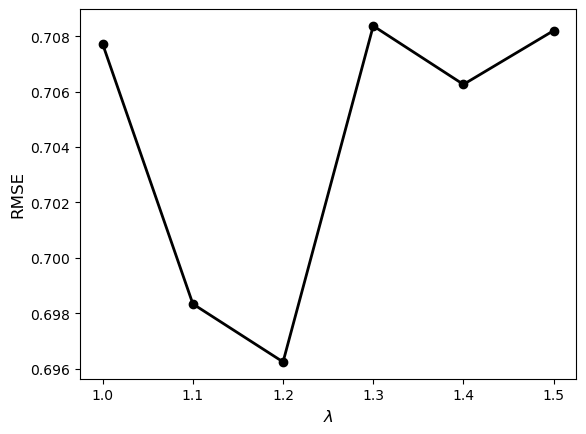

In [23]:
lambda_list = [1, 1.1, 1.2, 1.3, 1.4, 1.5]
mean_RMSE_list = []
for graph_lambda in lambda_list:
    with open(f'./Results/graph_lambda_{graph_lambda}.txt', 'r') as f:
        lambda_metrics = json.load(f)
        mean_RMSE = lambda_metrics["mean_RMSE"][-1]
        mean_RMSE_list.append(mean_RMSE)

# Plot the line chart
plt.plot(lambda_list, mean_RMSE_list, marker='o', color='black', linestyle='-', linewidth=2)
# Set the axis labels
plt.xlabel(r'$\lambda$', fontsize = 12)
plt.ylabel('RMSE', fontsize = 12)
plt.show()

plt.savefig('./Figures/Graph_lambda_test.png', format='png', dpi=300, bbox_inches='tight')

## 3.6 Hyperparameters Tuning

In [14]:
import itertools
# Define the hyperparameter grid
global_param_grid_DL = {
    'batch_size': [64, 128],
    'learning_rate': [0.001, 0.01],
    'weight_decay': [0.001, 0.01],
}

local_param_grid_DL = {
    'HighAir': {
    'gnn_out': [32],
    'lstm_hid': [64],
    'lstm_layers': [2],
    'temporal_emb': [16],
    'spatial_emb': [32], 
    'global_emb' : [8]
    },
    'REGAL': {
    'gat_hid': [32],
    'gat_out': [32],
    'dropout_prob': [0.5],
    'lstm_hid': [64],
    'lstm_layers': [2],
    'temporal_emb': [16],
    'spatial_emb': [32], 
    'global_emb' : [8]
    },
    'MLP': {
    'dropout_prob': [0.5],
    'fc_hid': [[32, 64, 128]] 
    },
    'GCN': {
    'gnn_hid': [32], 
    'gnn_out': [32],
    'dropout_prob': [0.4, 0.5]
    }, 
    'GAT': {
    'gat_hid': [16], 
    'gat_out': [64],
    'dropout_prob': [0.4, 0.5]
    }, 
    'GRU': {
    'gru_hid': [64], 
    'dropout_prob': [0.5]
    },
    'LSTM': {
    'lstm_hid': [64],
    'lstm_layers': [2]
    },
}
model_param_grid_DL = local_param_grid_DL["REGAL"]
param_grid = {**global_param_grid_DL, **model_param_grid_DL}
keys, values = zip(*param_grid.items())
# The permutation and combination of hyperparameters
hyperparameter_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

len(hyperparameter_combinations)

8

In [ ]:
# Define the dictionary for best results of each model during the grid search process
model_name_list = ["REGAL"] 
num_epochs = 100
repeat_times = 2

result_keys = ['hyperparameters', 'val_rmse', 'test_metrics', 'test_predictions', 'all_epochs_metrics']
best_results_dict = {key: None for key in result_keys}
best_val_rmse = 999
if_overwrite = False 

def save_progress(model_name, iteration_count, best_results_dict, total_cost_time, epoch_time):
    file_path = f'./Results/{model_name}_best_results.txt'
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, 'w') as f:
        json.dump({'iteration_count': iteration_count, 'total_cost_time': total_cost_time, 'epoch_time': epoch_time, 'best_results_dict': best_results_dict}, f)

def load_progress(model_name):
    file_path = f'./Results/{model_name}_best_results.txt'
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            data = json.load(f)
            return data['iteration_count'], data['best_results_dict'], data['total_cost_time'], data['epoch_time']
    return 0, {key: None for key in result_keys}, 0, 0

for model_name in model_name_list:
    # Merge the dictionaries
    model_param_grid_DL = local_param_grid_DL[model_name]
    param_grid = {**global_param_grid_DL, **model_param_grid_DL}
    keys, values = zip(*param_grid.items())
    # The permutation and combination of hyperparameters
    hyperparameter_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    num_search = len(hyperparameter_combinations)

    # Load progress
    if if_overwrite == False:
        iteration_count, best_results_dict, total_cost_time, epoch_time = load_progress(model_name)
        if iteration_count != 0:
            best_val_rmse = best_results_dict['val_rmse']  # else 999
    else: 
        iteration_count, best_results_dict, total_cost_time, epoch_time= 0, {key: None for key in result_keys}, 0, 0

    # Check if grid search is already finished
    if iteration_count == num_search: # 100 num_search
        print(f"The grid search of hyperparameters for {model_name} has already finished!")
        continue
        
    model_sta_time = time.perf_counter()
    # Generate all possible hyperparameter combinations using itertools.product
    for count, hyperparameters in enumerate(hyperparameter_combinations):
        if count+1 <= iteration_count: 
            continue  # Skip already processed combinations
        sta_time = time.perf_counter()
        print(f"Model {model_name}: the grid search progressed to {count+1}/{num_search}")
        print(hyperparameters)
        
        epoch_sta_time = time.perf_counter()  
        avg_val_rmse, best_test_metrics_stat, repeat_best_epochs_metrics, repeat_best_prediction, num_stop_epochs = Run_train_loop(model_name = model_name, repeat_times = repeat_times,
                                                                                                                                num_epochs = num_epochs, hyperparameters = hyperparameters, 
                                                                                                                                feat_set = "All", set_early_stop = True)
        epoch_time_new = time.perf_counter() - epoch_sta_time
        
        if avg_val_rmse < best_val_rmse:
            best_val_rmse = avg_val_rmse
            best_results_dict['hyperparameters'] = hyperparameters
            best_results_dict['val_rmse'] = avg_val_rmse
            best_results_dict['test_metrics'] = best_test_metrics_stat
            best_results_dict['test_predictions'] = repeat_best_prediction
            best_results_dict['all_epochs_metrics'] = repeat_best_epochs_metrics
            epoch_time = epoch_time_new/num_stop_epochs
            
        total_cost_time += (time.perf_counter() - sta_time)
        # Save progress after each iteration
        save_progress(model_name, count+1, best_results_dict, total_cost_time, epoch_time) 
        # epoch_time is the time cost each epoch for model with best_val_rmse 
    model_time_elapsed = (time.perf_counter() - model_sta_time) / 3600
    print(f"the grid search for Model {model_name} cost {round(model_time_elapsed, 2)} hours")

Model REGAL: the grid search progressed to 5/8
{'batch_size': 128, 'learning_rate': 0.001, 'weight_decay': 0.001, 'gat_hid': 32, 'gat_out': 32, 'dropout_prob': 0.5, 'lstm_hid': 64, 'lstm_layers': 2, 'temporal_emb': 16, 'spatial_emb': 32, 'global_emb': 8}
    train REGAL model for the 1-th time ...
    the Validate RMSE gets better in 1-th epoch
    the Validate RMSE gets better in 2-th epoch
    the Validate RMSE gets better in 3-th epoch
    the Validate RMSE gets better in 4-th epoch
    the Validate RMSE gets better in 5-th epoch
    the Validate RMSE gets better in 7-th epoch
    the Validate RMSE gets better in 8-th epoch
    the Validate RMSE gets better in 9-th epoch


epoch:  10, validate loss: 0.526: 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.47s/it]


    validate metrics in 10-th epoch: average 12 hours RMSE, MAE, PCC:  0.726 0.54 0.69


epoch:  10, test     loss: 0.467: 100%|█████████████████████████████████████████████████| 14/14 [00:20<00:00,  1.47s/it]


    the Validate RMSE gets better in 11-th epoch
    the Validate RMSE gets better in 14-th epoch
    the Validate RMSE gets better in 15-th epoch
    the Validate RMSE gets better in 16-th epoch


epoch:  20, validate loss: 0.503: 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]


    validate metrics in 20-th epoch: average 12 hours RMSE, MAE, PCC:  0.71 0.51 0.718


epoch:  20, test     loss: 0.494: 100%|█████████████████████████████████████████████████| 14/14 [00:20<00:00,  1.50s/it]


    the Validate RMSE gets better in 22-th epoch
    the Validate RMSE gets better in 23-th epoch
    the Validate RMSE gets better in 27-th epoch


epoch:  30, validate loss: 0.458: 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]


    validate metrics in 30-th epoch: average 12 hours RMSE, MAE, PCC:  0.677 0.492 0.737
    the Validate RMSE gets better in 30-th epoch


epoch:  30, test     loss: 0.458: 100%|█████████████████████████████████████████████████| 14/14 [00:20<00:00,  1.49s/it]


    the Validate RMSE gets better in 35-th epoch
    the Validate RMSE gets better in 39-th epoch


epoch:  40, validate loss: 0.457: 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.53s/it]


    validate metrics in 40-th epoch: average 12 hours RMSE, MAE, PCC:  0.677 0.484 0.747


epoch:  40, test     loss: 0.478: 100%|█████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.53s/it]


    the Validate RMSE gets better in 44-th epoch


epoch:  50, validate loss: 0.454: 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]


    validate metrics in 50-th epoch: average 12 hours RMSE, MAE, PCC:  0.673 0.491 0.741


epoch:  50, test     loss: 0.507: 100%|█████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.51s/it]


    the Validate RMSE gets better in 53-th epoch
    the Validate RMSE gets better in 54-th epoch
    the Validate RMSE gets better in 57-th epoch


epoch:  60, validate loss: 0.447: 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]


    validate metrics in 60-th epoch: average 12 hours RMSE, MAE, PCC:  0.669 0.486 0.745


epoch:  70, validate loss: 0.454: 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]


    validate metrics in 70-th epoch: average 12 hours RMSE, MAE, PCC:  0.674 0.481 0.748


epoch:  70, test     loss: 0.489: 100%|█████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.51s/it]


Early stopping triggered at epoch 77!
    77 epochs cost 231.79 minutes
    train REGAL model for the 2-th time ...
    the Validate RMSE gets better in 1-th epoch
    the Validate RMSE gets better in 2-th epoch
    the Validate RMSE gets better in 3-th epoch
    the Validate RMSE gets better in 4-th epoch
    the Validate RMSE gets better in 6-th epoch
    the Validate RMSE gets better in 7-th epoch
    the Validate RMSE gets better in 9-th epoch


epoch:  10, validate loss: 0.568: 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]


    validate metrics in 10-th epoch: average 12 hours RMSE, MAE, PCC:  0.753 0.562 0.675


epoch:  10, test     loss: 0.515: 100%|█████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.50s/it]


    the Validate RMSE gets better in 12-th epoch
    the Validate RMSE gets better in 14-th epoch
    the Validate RMSE gets better in 15-th epoch
    the Validate RMSE gets better in 19-th epoch


epoch:  20, validate loss: 0.505: 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]


    validate metrics in 20-th epoch: average 12 hours RMSE, MAE, PCC:  0.711 0.514 0.711


epoch:  20, test     loss: 0.482: 100%|█████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.51s/it]


    the Validate RMSE gets better in 21-th epoch
    the Validate RMSE gets better in 22-th epoch


epoch:  30, validate loss: 0.521: 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]


    validate metrics in 30-th epoch: average 12 hours RMSE, MAE, PCC:  0.722 0.514 0.717


epoch:  30, test     loss: 0.509: 100%|█████████████████████████████████████████████████| 14/14 [00:20<00:00,  1.48s/it]


    the Validate RMSE gets better in 31-th epoch
    the Validate RMSE gets better in 35-th epoch


epoch:  40, validate loss: 0.502: 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]


    validate metrics in 40-th epoch: average 12 hours RMSE, MAE, PCC:  0.707 0.511 0.714


epoch:  50, validate loss: 0.5: 100%|█████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]


    validate metrics in 50-th epoch: average 12 hours RMSE, MAE, PCC:  0.705 0.509 0.714


epoch:  50, test     loss: 0.519: 100%|█████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.50s/it]


Early stopping triggered at epoch 51!
    51 epochs cost 153.36 minutes
Model REGAL: the grid search progressed to 6/8
{'batch_size': 128, 'learning_rate': 0.001, 'weight_decay': 0.01, 'gat_hid': 32, 'gat_out': 32, 'dropout_prob': 0.5, 'lstm_hid': 64, 'lstm_layers': 2, 'temporal_emb': 16, 'spatial_emb': 32, 'global_emb': 8}
    train REGAL model for the 1-th time ...
    the Validate RMSE gets better in 1-th epoch
    the Validate RMSE gets better in 2-th epoch
    the Validate RMSE gets better in 3-th epoch
    the Validate RMSE gets better in 4-th epoch
    the Validate RMSE gets better in 5-th epoch
    the Validate RMSE gets better in 6-th epoch


epoch:  10, validate loss: 0.606: 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]


    validate metrics in 10-th epoch: average 12 hours RMSE, MAE, PCC:  0.779 0.587 0.63


epoch:  10, test     loss: 0.562: 100%|█████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.51s/it]


    the Validate RMSE gets better in 19-th epoch


epoch:  20, validate loss: 0.594: 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]


    validate metrics in 20-th epoch: average 12 hours RMSE, MAE, PCC:  0.771 0.581 0.639


epoch:  20, test     loss: 0.539: 100%|█████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.51s/it]


    the Validate RMSE gets better in 27-th epoch
    the Validate RMSE gets better in 29-th epoch


epoch:  30, validate loss: 0.593: 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]


    validate metrics in 30-th epoch: average 12 hours RMSE, MAE, PCC:  0.77 0.584 0.642


epoch:  30, test     loss: 0.539: 100%|█████████████████████████████████████████████████| 14/14 [00:20<00:00,  1.49s/it]


    the Validate RMSE gets better in 34-th epoch


epoch:  40, validate loss: 0.588: 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]


    validate metrics in 40-th epoch: average 12 hours RMSE, MAE, PCC:  0.766 0.58 0.644


epoch:  50, validate loss: 0.591: 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]


    validate metrics in 50-th epoch: average 12 hours RMSE, MAE, PCC:  0.768 0.582 0.643


epoch:  50, test     loss: 0.538: 100%|█████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.50s/it]


Early stopping triggered at epoch 54!
    54 epochs cost 162.64 minutes
    train REGAL model for the 2-th time ...
    the Validate RMSE gets better in 1-th epoch
    the Validate RMSE gets better in 2-th epoch
    the Validate RMSE gets better in 3-th epoch
    the Validate RMSE gets better in 4-th epoch
    the Validate RMSE gets better in 6-th epoch
    the Validate RMSE gets better in 7-th epoch
    the Validate RMSE gets better in 9-th epoch


epoch:  10, validate loss: 0.617: 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.52s/it]


    validate metrics in 10-th epoch: average 12 hours RMSE, MAE, PCC:  0.785 0.599 0.628


epoch:  10, test     loss: 0.568: 100%|█████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.52s/it]


    the Validate RMSE gets better in 18-th epoch


epoch:  20, validate loss: 0.614: 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.55s/it]


    validate metrics in 20-th epoch: average 12 hours RMSE, MAE, PCC:  0.782 0.595 0.632


epoch:  20, test     loss: 0.571: 100%|█████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.55s/it]


    the Validate RMSE gets better in 21-th epoch
    the Validate RMSE gets better in 27-th epoch


epoch:  30, validate loss: 0.568: 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.53s/it]


    validate metrics in 30-th epoch: average 12 hours RMSE, MAE, PCC:  0.754 0.569 0.659
    the Validate RMSE gets better in 30-th epoch


epoch:  30, test     loss: 0.53: 100%|██████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.52s/it]


    the Validate RMSE gets better in 38-th epoch


epoch:  40, validate loss: 0.563: 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]


    validate metrics in 40-th epoch: average 12 hours RMSE, MAE, PCC:  0.751 0.562 0.663


epoch:  50, validate loss: 0.563: 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.53s/it]


    validate metrics in 50-th epoch: average 12 hours RMSE, MAE, PCC:  0.75 0.561 0.663


epoch:  50, test     loss: 0.525: 100%|█████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.53s/it]


    the Validate RMSE gets better in 52-th epoch


epoch:  60, validate loss: 0.557: 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]


    validate metrics in 60-th epoch: average 12 hours RMSE, MAE, PCC:  0.746 0.562 0.668


epoch:  60, test     loss: 0.52: 100%|██████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.50s/it]


    the Validate RMSE gets better in 68-th epoch


# 4 Results Visualization

### 4.1 Load all model results

In [6]:
# Load the saved results of all models
model_name_list = ["MLP", "GRU", "GCN", "HighAir", "REGAL"] #  ["REGAL", "DSTGCN", "HighAir"] 
def Load_model_results(model_name_list):
    all_model_metrics, all_model_hyperparams, all_model_predictions, all_model_epoch_metrics, all_model_epoch_time= {}, {}, {}, {}, {}
    for model_name in model_name_list:
        # Load current best_results_dict in grid search for model
        with open(f'./Results/{model_name}_results.txt', 'r') as f:
            model_results = json.load(f)

        model_metrics_dict = model_results['best_results_dict']['test_metrics']
        model_hyperparams_dict = model_results['best_results_dict']['hyperparameters']  
        model_predictions_dict = model_results['best_results_dict']['test_predictions']
        model_epochs_metrics = model_results['best_results_dict']['all_epochs_metrics']
        epoch_time = model_results['epoch_time']
        
        all_model_metrics[model_name] = model_metrics_dict
        all_model_hyperparams[model_name] = model_hyperparams_dict
        all_model_predictions[model_name] = model_predictions_dict
        all_model_epoch_metrics[model_name] = model_epochs_metrics
        all_model_epoch_time[model_name] = epoch_time
        
    return all_model_metrics, all_model_hyperparams, all_model_predictions, all_model_epoch_metrics, all_model_epoch_time

all_model_metrics, all_model_hyperparams, all_model_predictions, all_model_epoch_metrics, all_model_epoch_time = Load_model_results(model_name_list)

In [19]:
all_model_metrics

{'MLP': {'mean_RMSE': [0.576662383418753,
   0.7394277197365792,
   0.8140342647184213,
   0.7169532536263515],
  'std_RMSE': [0.0027816030318160074,
   0.014015895245483703,
   0.029851889515193932,
   0.016862204756626337],
  'mean_MAE': [0.42241495847702026,
   0.5502104461193085,
   0.6116239130496979,
   0.5280831158161163],
  'std_MAE': [0.0022902597480819816,
   0.011457831501929097,
   0.02379514129173502,
   0.012514284406703166],
  'mean_PCC': [0.8180051247004104,
   0.6772670529476699,
   0.591644935671127,
   0.6999140640995916],
  'std_PCC': [0.0008843153383229533,
   0.01364177293419359,
   0.03404600600255494,
   0.015986085689188842]},
 'GRU': {'mean_RMSE': [0.5365289398679441,
   0.6813019410315697,
   0.7165528284677345,
   0.649489401034665],
  'std_RMSE': [0.00041313859618735135,
   0.010796023987765151,
   0.011628055208514374,
   0.008164844093630497],
  'mean_MAE': [0.38314196467399597,
   0.5061203092336655,
   0.5358954668045044,
   0.475052610039711],
  'std_M

In [68]:
all_model_epoch_metrics

{'REGAL': {'train': {'RMSE': [[0.891339199743983,
     0.8965649205012604,
     0.9077654368402036,
     0.912409632924281,
     0.9056042310651266]],
   'MAE': [[0.7124168872833252,
     0.715836226940155,
     0.7237786650657654,
     0.7261990308761597,
     0.7219380736351013]],
   'PCC': [[0.5285468490778291,
     0.5009530962665423,
     0.46088415894091994,
     0.44552579970713296,
     0.4683792848166116]]},
  'validate': {'RMSE': [[0.8461093411545731,
     0.8761934588116965,
     0.917778255095241,
     0.9386212002287015,
     0.911233943384357]],
   'MAE': [[0.6955541968345642,
     0.7207211256027222,
     0.7537267804145813,
     0.7681427597999573,
     0.7475303411483765]],
   'PCC': [[0.6228300514708587,
     0.5576970204188725,
     0.47231740523374915,
     0.43118775363237977,
     0.4858352824996942]]},
  'test': {'RMSE': [[0.8468983509743582,
     0.8804605938889924,
     0.9299696165679624,
     0.9492917758810038,
     0.9203640468390697]],
   'MAE': [[0.707225

### 4.2 Model Learning Record

In [20]:
all_model_hyperparams

{'MLP': {'batch_size': 128,
  'learning_rate': 0.001,
  'weight_decay': 0.001,
  'graph_lambda': 1.2,
  'dropout_prob': 0.5,
  'hidden_size': [32, 64, 128]},
 'GRU': {'batch_size': 64,
  'learning_rate': 0.001,
  'weight_decay': 0.001,
  'gru_hid': 64,
  'dropout_prob': 0.5},
 'GCN': {'batch_size': 128,
  'learning_rate': 0.01,
  'weight_decay': 0.001,
  'gnn_hid': 32,
  'gnn_out': 32,
  'dropout_prob': 0.5},
 'REGAL': {'learning_rate': 0.001,
  'weight_decay': 0.001,
  'num_epochs': 1,
  'batch_size': 64,
  'graph_lambda': 1.2,
  'gat_hid': 16,
  'gat_out': 8,
  'dropout_prob': 0.5,
  'lstm_hid': 64,
  'lstm_layers': 1,
  'temporal_emb': 16,
  'spatial_emb': 24,
  'global_emb': 12}}

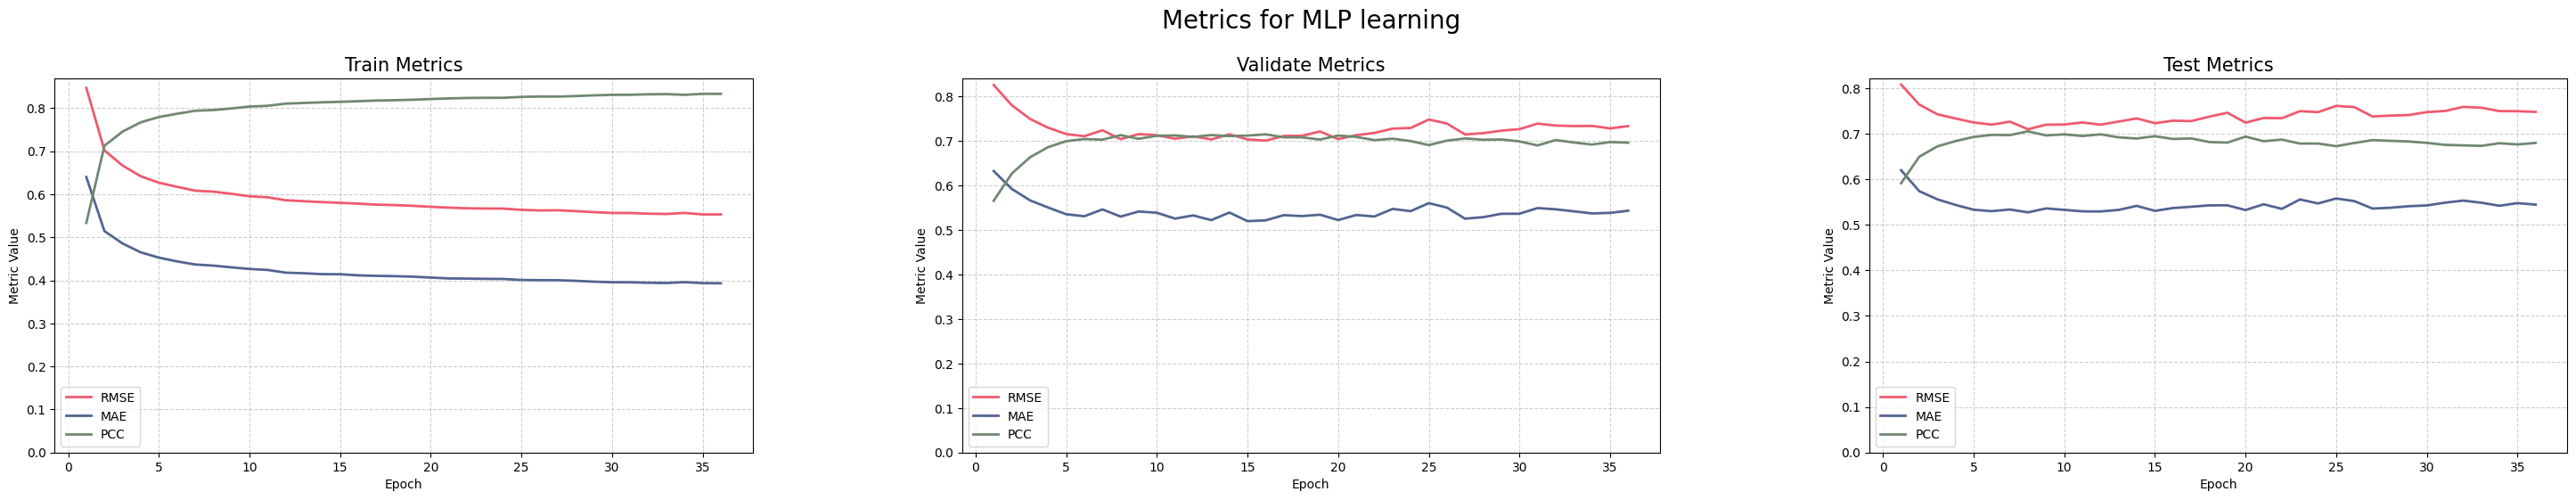

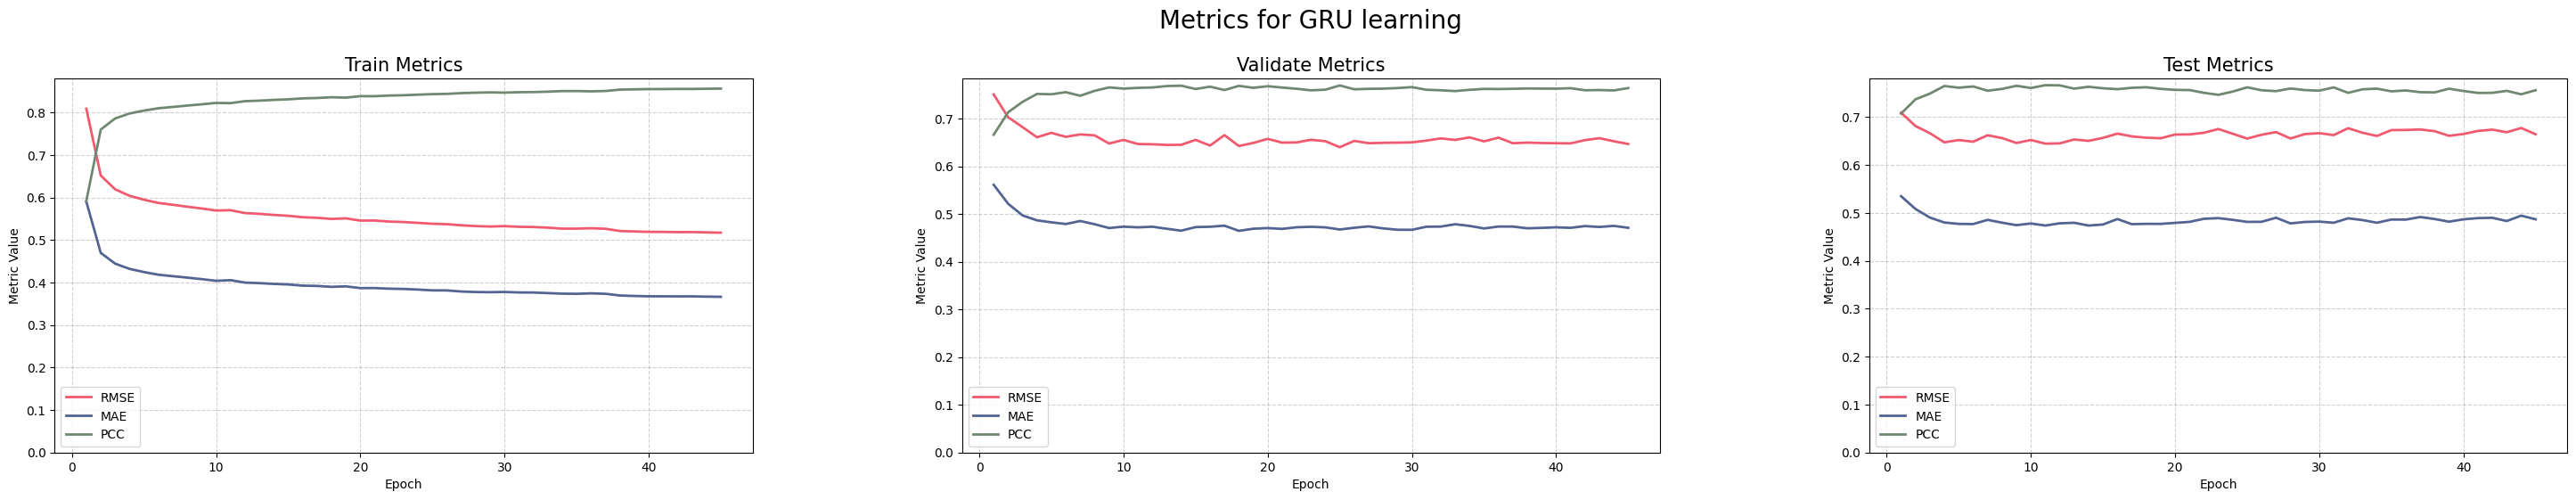

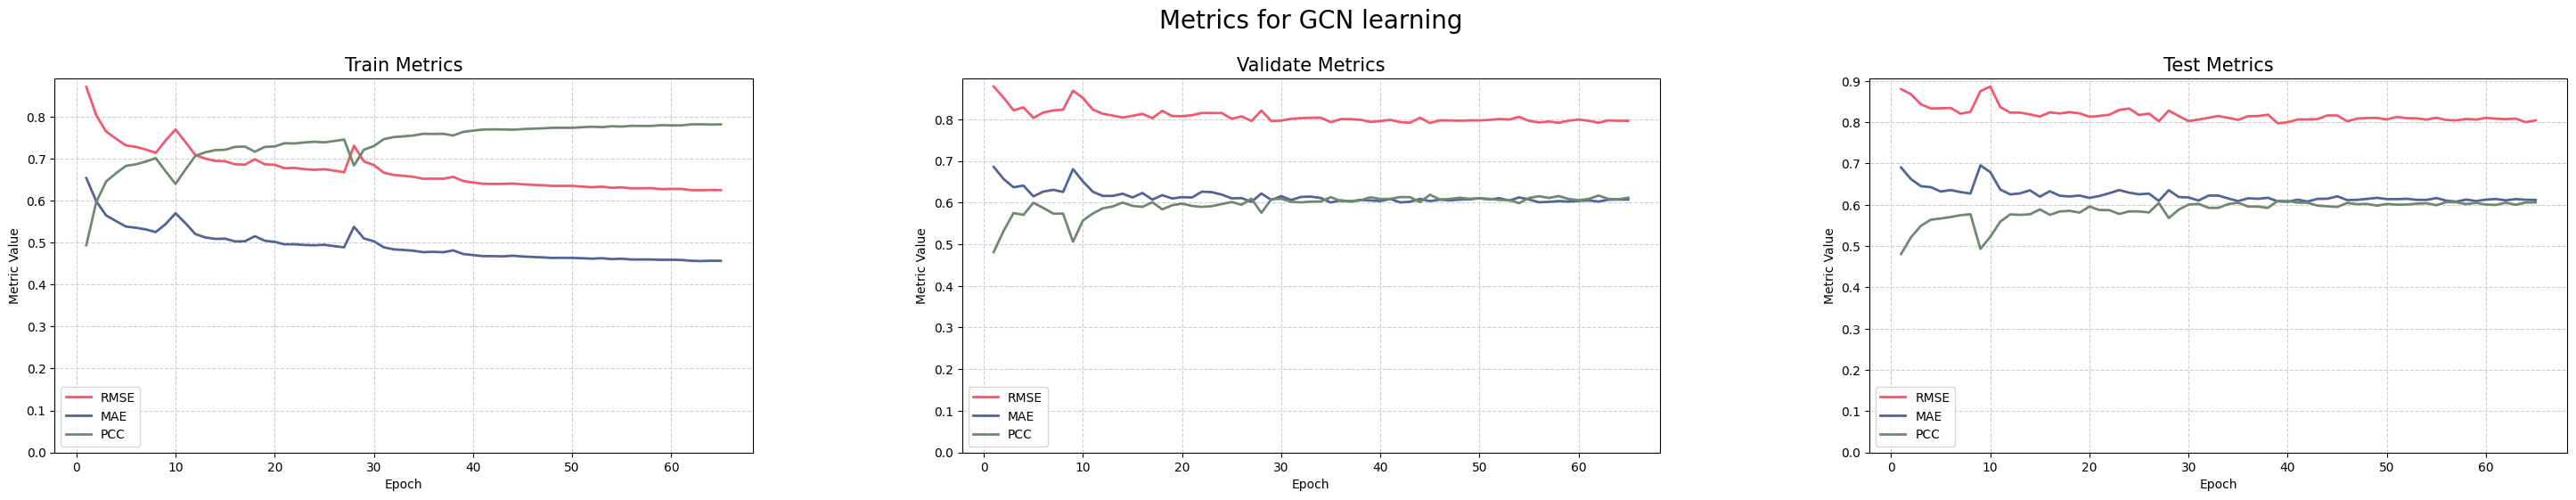

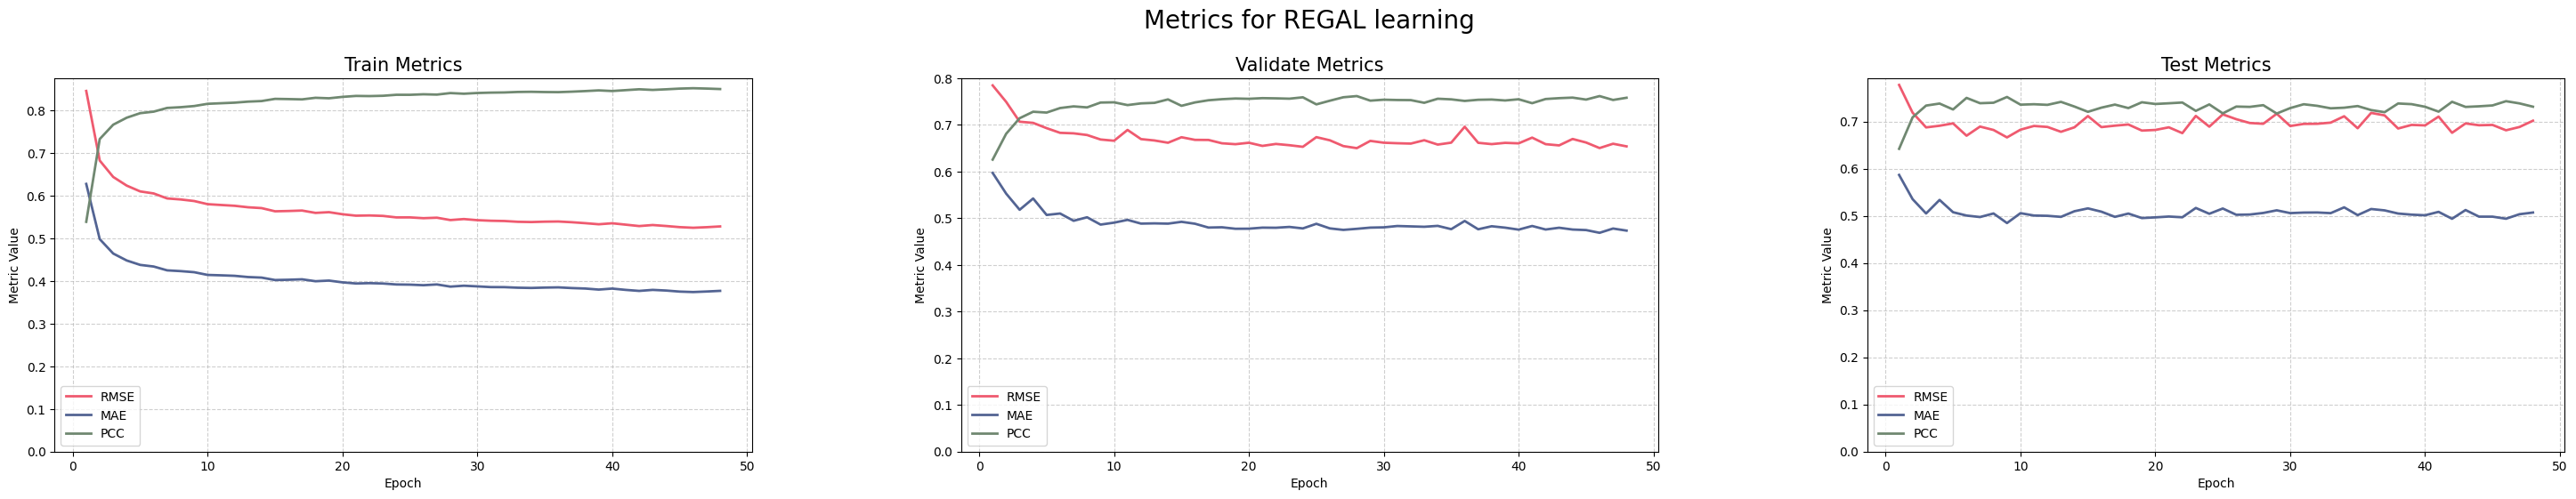

In [14]:
phases = ['train', 'validate', 'test']
colors = {'RMSE': '#EF5A6F', 'MAE': '#536493', 'PCC': '#708871'}
model_name_list = ["MLP", "GRU", "GCN", "REGAL"]
num_epochs = 100
for model_name in model_name_list:  
    all_epoch_metrics = all_model_epoch_metrics[model_name]
    num_epochs = len(all_epoch_metrics["train"]["RMSE"])
    epochs = list(range(1, num_epochs+1))
    fig, axes = plt.subplots(1, 3, figsize=(30, 6), sharex=True)
    for i, phase in enumerate(phases):
        for metric_name in ['RMSE', 'MAE', 'PCC']:
                metric_line = np.array(all_epoch_metrics[phase][metric_name])
                axes[i].plot(epochs, metric_line[:, -1], label=metric_name, color=colors[metric_name], linewidth=2.0)
                axes[i].set_xlabel('Epoch')
                axes[i].set_ylabel('Metric Value')
                axes[i].set_title(f'{phase.capitalize()} Metrics', fontsize=15)
                axes[i].legend()
                # Set grid to be dashed lines with adjusted transparency
                axes[i].grid(True, linestyle='--', alpha=0.6)
                # Set y-axis ticks with an interval of 0.1
                _, ymax = axes[i].get_ylim()
                ymax = np.ceil(ymax / 0.1) * 0.1
                axes[i].set_yticks(np.arange(0, ymax, 0.1))

    fig.suptitle(f'Metrics for {model_name} learning', fontsize=20)

    plt.subplots_adjust(left=0.03, right=0.97, top=0.85, bottom=0.15, wspace=0.3)

    plt.savefig(f'./Results/Learning_Records/Learning_record_{model_name}.png')

### 4.3 Model Performance

In [27]:
# Best hyperparameter set for each model
all_model_hyperparams

{'MLP': {'batch_size': 128,
  'learning_rate': 0.001,
  'weight_decay': 0.001,
  'graph_lambda': 1.2,
  'dropout_prob': 0.5,
  'hidden_size': [32, 64, 128]},
 'GRU': {'batch_size': 64,
  'learning_rate': 0.001,
  'weight_decay': 0.001,
  'gru_hid': 64,
  'dropout_prob': 0.5},
 'GCN': {'batch_size': 128,
  'learning_rate': 0.01,
  'weight_decay': 0.001,
  'gnn_hid': 32,
  'gnn_out': 32,
  'dropout_prob': 0.5},
 'REGAL': {'learning_rate': 0.001,
  'weight_decay': 0.001,
  'num_epochs': 1,
  'batch_size': 64,
  'graph_lambda': 1.2,
  'gat_hid': 16,
  'gat_out': 8,
  'dropout_prob': 0.5,
  'lstm_hid': 64,
  'lstm_layers': 1,
  'temporal_emb': 16,
  'spatial_emb': 24,
  'global_emb': 12}}

In [9]:
with open('./Data/Array_data/Y_mean_std_dict.pkl', 'rb') as f:
    Y_mean_std_dict = pickle.load(f)
Y_test_std = Y_mean_std_dict['test'][1]

model_name_list = ["MLP", "GRU", "GCN", "REGAL"]

def Get_model_metrics(model_name):
    model_metrics_str = []
    for metric in ["RMSE", "MAE", "PCC"]:
        mean_key = f"mean_{metric}"
        std_key = f"std_{metric}"
        # Concatenate all "mean" and "std" corresponding values
        for mean, std in zip(all_model_metrics[model_name][mean_key][:-1], all_model_metrics[model_name][std_key][:-1]): 
            if metric != "PCC":
                # Destandardization
                mean = mean * Y_test_std[0]
                std = std * Y_test_std[0]
                # Append mean and std values to model_metrics list  
            model_metrics_str.append(f"{round(mean, 2)}±{round(std, 2)}")
    return model_metrics_str 
    
try:
    VAR_metrics = Get_model_metrics("VAR")
except (FileNotFoundError, KeyError):
    VAR_metrics = [0] * 9

try:
    MLP_metrics = Get_model_metrics("MLP")
except (FileNotFoundError, KeyError):
    MLP_metrics = [0] * 9

try:
    GCN_metrics = Get_model_metrics("GCN")
except (FileNotFoundError, KeyError):
    GCN_metrics = [0] * 9

try:
    GRU_metrics = Get_model_metrics("GRU")
except (FileNotFoundError, KeyError):
    GRU_metrics = [0] * 9

try:
    HighAir_metrics = Get_model_metrics("HighAir")
except (FileNotFoundError, KeyError):
    HighAir_metrics = [0] * 9

try:
    REGAL_metrics = Get_model_metrics("REGAL")
except (FileNotFoundError, KeyError):
    REGAL_metrics = [0] * 9

# Define main column names and sub-column names
metric_columns = ["RMSE", "MAE", "PCC"]
timespan_columns = ["1-4h", "5-8h", "9-12h"]
main_column_name = ["Model"] + [item for item in metric_columns for _ in range(3)]
sub_columns = [""] + timespan_columns * 3

# Create multi-level column index
columns = [
    main_column_name,
    sub_columns
]
column_names = pd.MultiIndex.from_arrays(columns)

model_metrics = [["VAR"] + VAR_metrics,
        ["MLP"] + MLP_metrics,
        ["GCN"] + GCN_metrics,
        ["GRU"] + GRU_metrics,
        ["HighAir"] + HighAir_metrics,
        ["REGAL"] + REGAL_metrics]

metric_table = pd.DataFrame(model_metrics, columns=column_names)

# Set the "Model" column as the index and remove the default integer index
metric_table.set_index(('Model', ''), inplace=True)

# Rename the index name for clarity
metric_table.index.name = 'Model'

metric_table

RMSE                                MAE              \
               1-4h        5-8h       9-12h       1-4h        5-8h   
Model                                                                
VAR               0           0           0          0           0   
MLP      10.16±0.05  13.03±0.25  14.35±0.53  7.44±0.04     9.7±0.2   
GCN      12.46±0.12   14.51±0.2   15.64±0.2  9.42±0.12  11.06±0.16   
GRU       9.87±0.18  12.85±0.18  13.43±0.18  7.05±0.19   9.46±0.19   
HighAir    9.8±0.12  12.74±0.06  13.59±0.39   7.1±0.06   9.45±0.03   
REGAL     9.46±0.01  12.01±0.19   12.63±0.2  6.75±0.05   8.92±0.22   

                           PCC                        
              9-12h       1-4h       5-8h      9-12h  
Model                                                 
VAR               0          0          0          0  
MLP      10.78±0.42   0.82±0.0  0.68±0.01  0.59±0.03  
GCN      12.04±0.13  0.71±0.01  0.58±0.01  0.49±0.01  
GRU      10.02±0.19  0.83±0.01   0.7±0.01  0.67±0.01  
HighAir  10.08±0.22  0.83±0.01   0.71±0.0  0.67±0.01  
REGAL     9.44±0.21   0.84±0.0  0.74±0.01  0.71±0.01

In [6]:
# Obtain metrics of all the model
print("The Model of Best Performance in each epoch:")

# Initialize the dictionary to store the best values
metric_columns = ["RMSE", "MAE", "PCC"]
timespan_columns = ["1-4h", "5-8h", "9-12h"]

# Simplify the generation of best_metrics
best_metrics = {
    metric: {timespan: float('inf') if metric in ["RMSE", "MAE"] else float('-inf') for timespan in timespan_columns}
    for metric in metric_columns
}

# Simplify the generation of best_models
best_models = {
    metric: {timespan: '' for timespan in timespan_columns}
    for metric in metric_columns
}

# Compare and find the best values and corresponding models
for model_name, metrics in all_model_metrics.items():
    for metric in metric_columns:
        for i, timespan in enumerate(timespan_columns):
            if metric == "PCC":
                if metrics[f'mean_{metric}'][i] > best_metrics[metric][timespan]:
                    best_metrics[metric][timespan] = round(metrics[f'mean_{metric}'][i], 3)
                    best_models[metric][timespan] = model_name
            else:
                if metrics[f'mean_{metric}'][i] < best_metrics[metric][timespan]:
                    best_metrics[metric][timespan] = round(metrics[f'mean_{metric}'][i], 3)
                    best_models[metric][timespan] = model_name

# Print results
for metric in ['RMSE', 'MAE', 'PCC']:
    for timespan in ['1-4h', '5-8h', '9-12h']:
        print(f'Best mean_{metric} for {timespan}: {best_models[metric][timespan]}: {best_metrics[metric][timespan]}')


The Model of Best Performance in each epoch:
Best mean_RMSE for 1-4h: REGAL: 0.537
Best mean_RMSE for 5-8h: REGAL: 0.681
Best mean_RMSE for 9-12h: REGAL: 0.717
Best mean_MAE for 1-4h: REGAL: 0.383
Best mean_MAE for 5-8h: REGAL: 0.506
Best mean_MAE for 9-12h: REGAL: 0.536
Best mean_PCC for 1-4h: REGAL: 0.845
Best mean_PCC for 5-8h: REGAL: 0.74
Best mean_PCC for 9-12h: REGAL: 0.711


In [10]:
# Output tables to Word
from docx import Document
import re

# Assuming dataframes is a list of (DataFrame, table name) tuples
Output_tables_dict = [
    (metric_table, 'Prediction accuracy compared with baselines') #,
    # (metric_table, 'Table 2 Title'),
    # Add more DataFrame and table name pairs
]

# Create a new Word document
doc = Document()

for df, table_title in Output_tables_dict:
    # Add table title as a heading
    doc.add_heading(table_title, level=2)
    
    # Add a table with a row for the header
    table = doc.add_table(rows=2, cols=len(df.columns) + 1)

    # Initialize header cells
    hdr_cells = table.rows[0].cells  # Add header row: first level (metric)
    sub_hdr_cells = table.rows[1].cells # Add header row: second level (timespan)
    hdr_cells[0].text = ' # Set the index column header'
    sub_hdr_cells[0].text = 'Model' 

    for i, column_name in enumerate(df.columns):
        metric, timespan = column_name
        hdr_cells[i + 1].text = metric # Metric header
        sub_hdr_cells[i + 1].text = timespan  # Timespan header

    # Merge the cells in the first header row where necessary
    for i in range(1, len(df.columns) + 1):
        table.cell(0, i).merge(table.cell(1, i))
    
    # Add table content
    for index, row in df.iterrows():
        row_cells = table.add_row().cells
        row_cells[0].text = str(index)  # Add the index (model) to the first cell
        for i, cell in enumerate(row):
            row_cells[i + 1].text = str(cell)

# Save the document
doc.save('./Result_tables.docx')

### 4.4 Prediction Curves

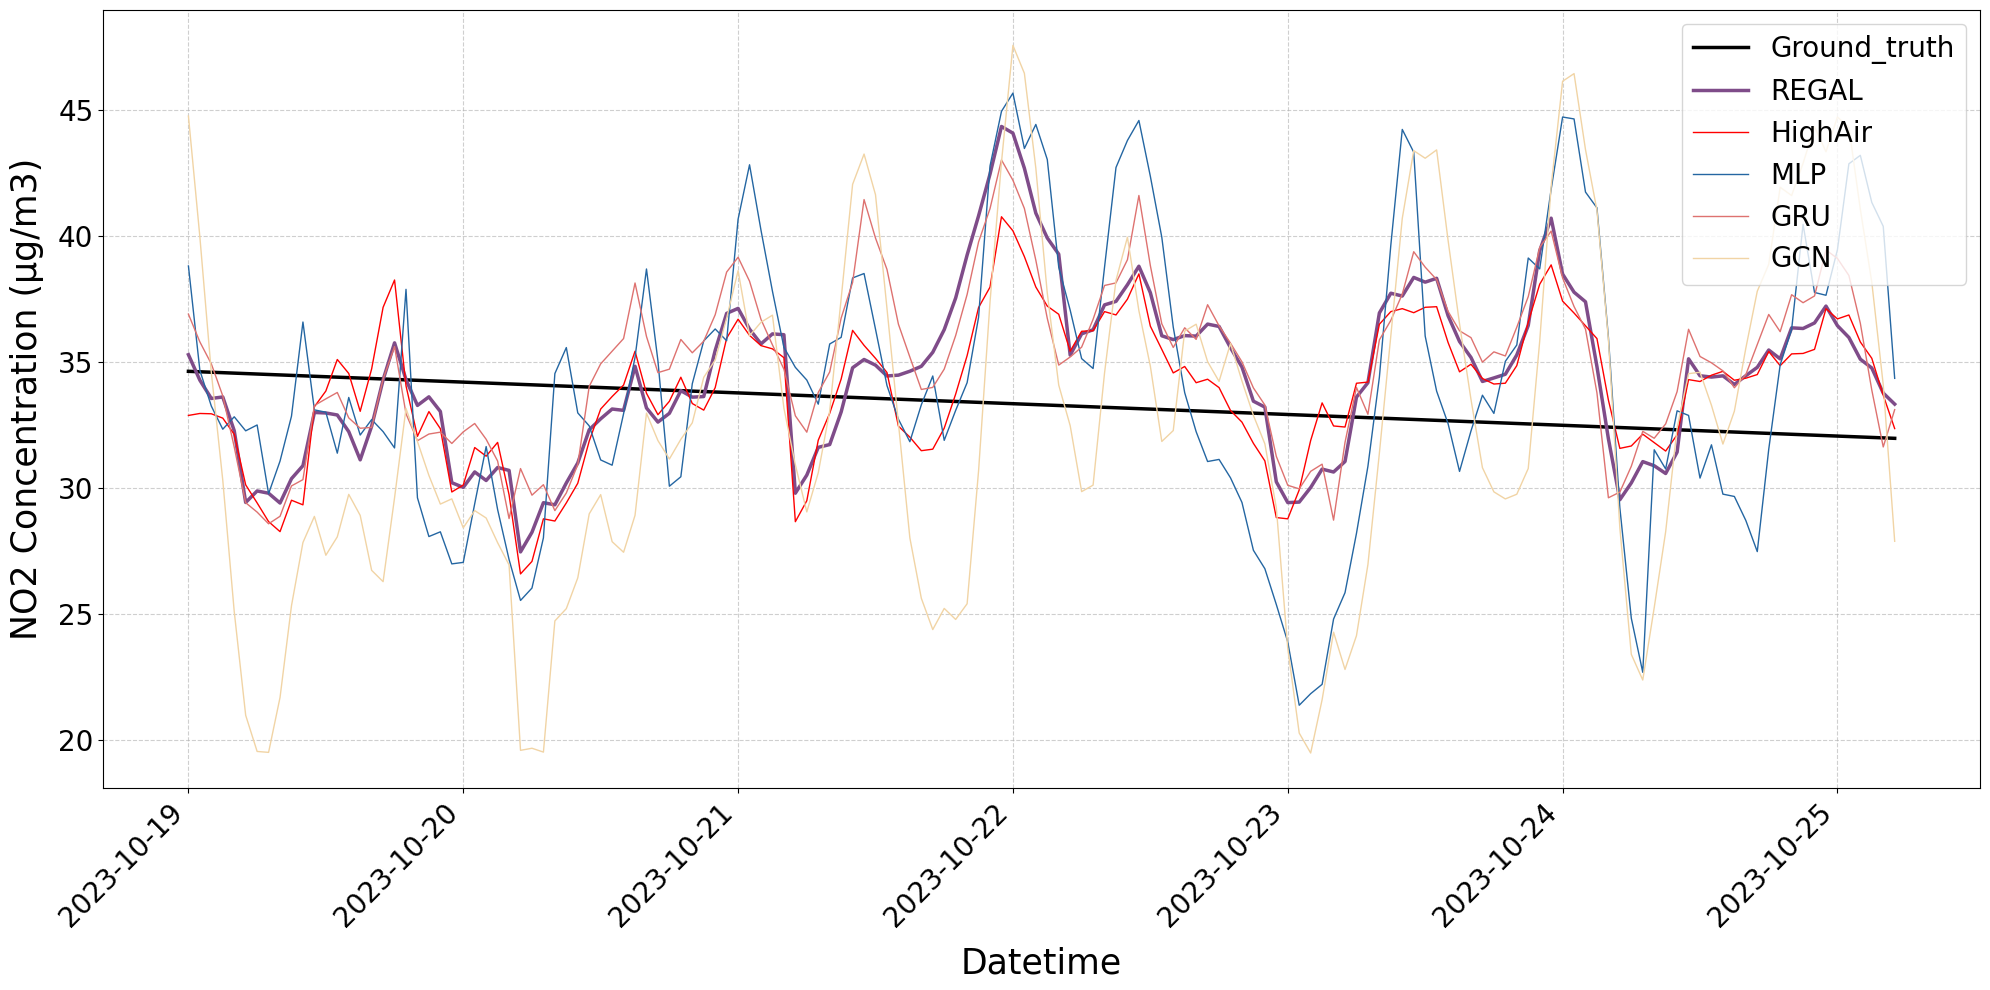

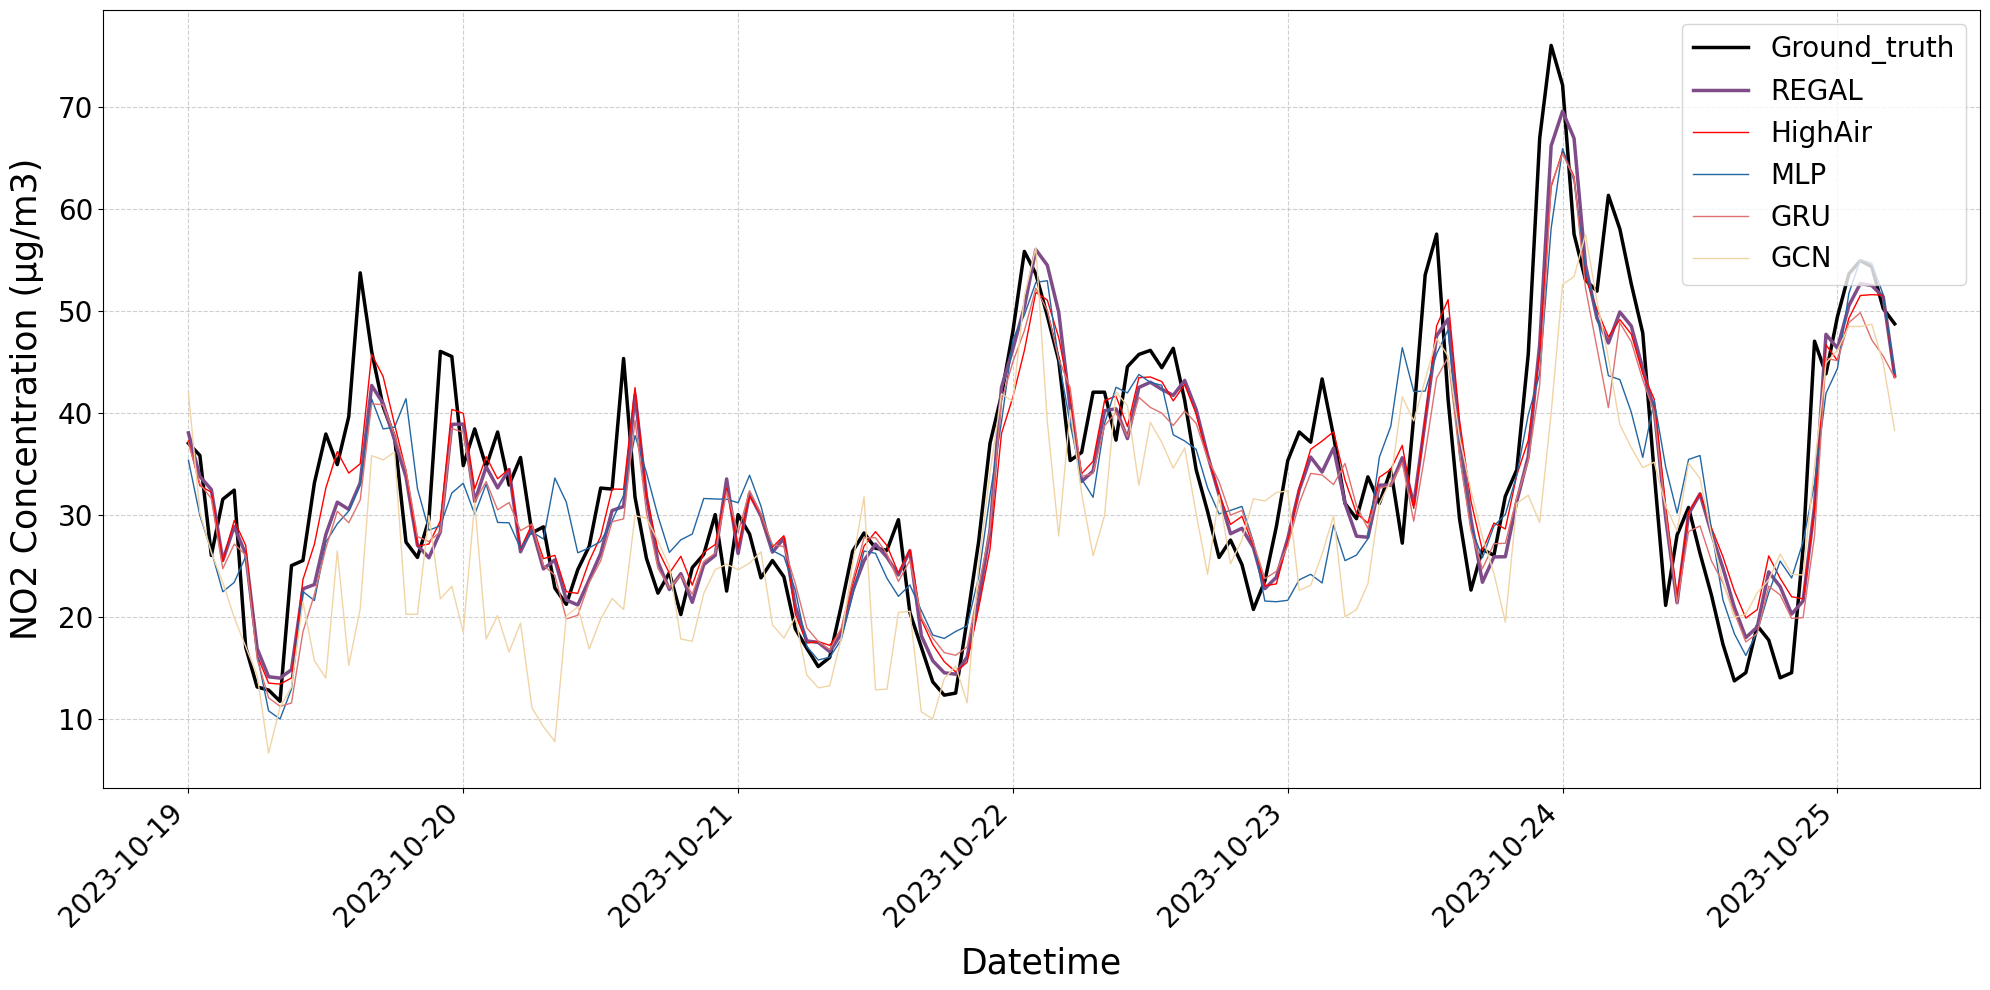

CPU times: total: 26.4 s
Wall time: 26.4 s


In [30]:
%%time
Stations_NO2 = gpd.read_file("./Data/Stations_NO2.geojson")

with open('./Data/Array_data/Y_mean_std_dict.pkl', 'rb') as f:
    Y_mean_std_dict = pickle.load(f)

# Flag to display only the first image
show_first_two_plot = 0
model_name_list = ["REGAL", "HighAir","MLP", "GRU", "GCN"] # "MLP", "GRU", "GCN", 
clip_slice = slice(0,150)
sequence_len = clip_slice.stop - clip_slice.start

for station_idx in range(len(Stations_NO2)):
    # Plot the time series of predictions of all models in test phase
    Y_test_mean, Y_test_std = Y_mean_std_dict['test'][0], Y_mean_std_dict['test'][1]
    truth_array = np.array(Y_test_torch[:, station_idx, 0])
    ori_truth_array = truth_array * Y_test_std + Y_test_mean

    # Generate the date range with hourly intervals ending at end_time, including the end time
    date_range = pd.date_range(end=pd.Timestamp('2023-12-31 12:00:00'), periods=truth_array.shape[0], freq='h', inclusive='right')
    date_range_cliped = date_range[clip_slice]
    start_time = date_range_cliped[0].strftime('%Y-%m-%d %H:%M:%S')
    end_time = date_range_cliped[-1].strftime('%Y-%m-%d %H:%M:%S')

    # Create a DataFrame with the date range
    ori_pred_df = pd.DataFrame({'Datetime': date_range, 'Ground_truth': ori_truth_array})

    for model_name in model_name_list:
        pred_array = np.array(all_model_predictions[model_name])[:, station_idx, 0]
        ori_pred_array = pred_array * Y_test_std + Y_test_mean
        ori_pred_df[model_name] = ori_pred_array

    # Plotting the line chart
    plt.figure(figsize=(20, 10))
    colors = ['black', '#7f4c89', 'red', "#2466a2", "#de7270", "#f1d4a5"]
    for i, model in enumerate(ori_pred_df.columns[1:]):
        if model == 'Ground_truth' or model == 'REGAL':
            plt.plot(ori_pred_df["Datetime"][clip_slice], ori_pred_df[model][clip_slice], label=model, color=colors[i], linewidth=2.5)
        else:
            plt.plot(ori_pred_df["Datetime"][clip_slice], ori_pred_df[model][clip_slice], label=model, color=colors[i], linewidth=1) # :, -., --  linestyle='-'

    # Adjusting tick parameters for x and y axis to increase font size
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)

    # Setting the labels and title
    plt.xlabel('Datetime', fontsize=25, labelpad=10)
    plt.ylabel('NO2 Concentration (μg/m3)', fontsize=25, labelpad=10)
    # Adjusting the legend to be horizontally aligned at the top of the plot
    plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1), ncol=1, fontsize=20)  # Horizontal Alignment, first for left-right, second for bottom-top (0-1)
    # Formatting x-axis to show complete start and end time
    freq_day = math.floor(sequence_len/24/6)
    plt.xticks(pd.date_range(start=start_time, end=end_time, freq=f'{freq_day}D'), rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Save the plot to a file
    SiteCode = Stations_NO2.iloc[station_idx]["SiteCode"]
    plt.savefig(f'./Results/Prediction_Curves/Station_{SiteCode}.png')

    # Show only the first image
    show_first_two_plot += 1
    if show_first_two_plot <=2:
        plt.show()
    else:
        plt.close()
    

# 5 Ablation Study

## 5.1 Feature evaluation

In [9]:
ablation_feat_dict = {
    "wo_spatial_1": ["spatial", slice(10,20), "w/o Road Condition"],              
    "wo_spatial_2": ["spatial", [slice(0, 10), slice(14, 20)], "w/o Land Use"],   
    "wo_spatial_3": ["spatial", slice(0, 14), "w/o Traffic Volume"],              
    "wo_temporal_1": ["temporal", slice(1, 9), "w/o NO2"],                        
    "wo_temporal_2": ["temporal", 0, "w/o Meteorology"],  
}

In [33]:
_, best_hyperparams, _, _, _ = Load_model_results(["REGAL"])
for feat_set in ablation_feat_dict.keys():
    file_path = f'./Results/Ablation/{feat_set}.txt'
    if os.path.exists(file_path):
        pass
    else:
        print(f"The ablation test progresses to {feat_set}")
        _, test_metrics, _, _, _ = Run_train_loop("REGAL", repeat_times=1, num_epochs=100, hyperparameters=best_hyperparams["REGAL"], feat_set=feat_set, set_early_stop=True)  # all_model_hyperparams["REGAL"]
        with open(file_path, 'w') as f:
            json.dump(test_metrics, f)

The ablation test progresses to wo_spatial_1
    train REGAL model for the 1-th time ...
    the Validate RMSE gets better in 1-th epoch
    the Validate RMSE gets better in 2-th epoch
    the Validate RMSE gets better in 3-th epoch
    the Validate RMSE gets better in 4-th epoch
    the Validate RMSE gets better in 5-th epoch
    the Validate RMSE gets better in 6-th epoch
    the Validate RMSE gets better in 7-th epoch
    the Validate RMSE gets better in 8-th epoch
    the Validate RMSE gets better in 9-th epoch


epoch:  10, validate loss: 0.459: 100%|█████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.32it/s]


    validate metrics in 10-th epoch: average 12 hours RMSE, MAE, PCC:  0.68 0.504 0.735
    the Validate RMSE gets better in 10-th epoch


epoch:  10, test     loss: 0.466: 100%|█████████████████████████████████████████████████| 28/28 [00:21<00:00,  1.32it/s]


    the Validate RMSE gets better in 11-th epoch
    the Validate RMSE gets better in 15-th epoch
    the Validate RMSE gets better in 18-th epoch


epoch:  20, validate loss: 0.431: 100%|█████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.32it/s]


    validate metrics in 20-th epoch: average 12 hours RMSE, MAE, PCC:  0.659 0.48 0.754
    the Validate RMSE gets better in 20-th epoch


epoch:  30, validate loss: 0.443: 100%|█████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.29it/s]


    validate metrics in 30-th epoch: average 12 hours RMSE, MAE, PCC:  0.669 0.48 0.751


epoch:  30, test     loss: 0.47: 100%|██████████████████████████████████████████████████| 28/28 [00:21<00:00,  1.30it/s]


    the Validate RMSE gets better in 34-th epoch


epoch:  40, validate loss: 0.438: 100%|█████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.30it/s]


    validate metrics in 40-th epoch: average 12 hours RMSE, MAE, PCC:  0.665 0.488 0.749


epoch:  50, validate loss: 0.437: 100%|█████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s]


    validate metrics in 50-th epoch: average 12 hours RMSE, MAE, PCC:  0.664 0.481 0.749


epoch:  50, test     loss: 0.498: 100%|█████████████████████████████████████████████████| 28/28 [00:20<00:00,  1.35it/s]


Early stopping triggered at epoch 54!
    54 epochs cost 164.14 minutes
The ablation test progresses to wo_spatial_2
    train REGAL model for the 1-th time ...
    the Validate RMSE gets better in 1-th epoch
    the Validate RMSE gets better in 2-th epoch
    the Validate RMSE gets better in 3-th epoch
    the Validate RMSE gets better in 4-th epoch
    the Validate RMSE gets better in 5-th epoch
    the Validate RMSE gets better in 6-th epoch
    the Validate RMSE gets better in 7-th epoch
    the Validate RMSE gets better in 9-th epoch


epoch:  10, validate loss: 0.449: 100%|█████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s]


    validate metrics in 10-th epoch: average 12 hours RMSE, MAE, PCC:  0.673 0.493 0.741


epoch:  10, test     loss: 0.463: 100%|█████████████████████████████████████████████████| 28/28 [00:20<00:00,  1.38it/s]


    the Validate RMSE gets better in 12-th epoch
    the Validate RMSE gets better in 16-th epoch
    the Validate RMSE gets better in 18-th epoch
    the Validate RMSE gets better in 19-th epoch


epoch:  20, validate loss: 0.439: 100%|█████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.40it/s]


    validate metrics in 20-th epoch: average 12 hours RMSE, MAE, PCC:  0.665 0.481 0.755


epoch:  30, validate loss: 0.437: 100%|█████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.40it/s]


    validate metrics in 30-th epoch: average 12 hours RMSE, MAE, PCC:  0.664 0.475 0.757


epoch:  30, test     loss: 0.478: 100%|█████████████████████████████████████████████████| 28/28 [00:20<00:00,  1.40it/s]


Early stopping triggered at epoch 39!
    39 epochs cost 116.4 minutes
The ablation test progresses to wo_spatial_3
    train REGAL model for the 1-th time ...
    the Validate RMSE gets better in 1-th epoch
    the Validate RMSE gets better in 2-th epoch
    the Validate RMSE gets better in 3-th epoch
    the Validate RMSE gets better in 5-th epoch
    the Validate RMSE gets better in 6-th epoch
    the Validate RMSE gets better in 7-th epoch
    the Validate RMSE gets better in 8-th epoch
    the Validate RMSE gets better in 9-th epoch


epoch:  10, validate loss: 0.484: 100%|█████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.32it/s]


    validate metrics in 10-th epoch: average 12 hours RMSE, MAE, PCC:  0.698 0.5 0.742


epoch:  10, test     loss: 0.476: 100%|█████████████████████████████████████████████████| 28/28 [00:21<00:00,  1.32it/s]


    the Validate RMSE gets better in 12-th epoch
    the Validate RMSE gets better in 15-th epoch
    the Validate RMSE gets better in 19-th epoch


epoch:  20, validate loss: 0.439: 100%|█████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.33it/s]


    validate metrics in 20-th epoch: average 12 hours RMSE, MAE, PCC:  0.665 0.477 0.755


epoch:  20, test     loss: 0.473: 100%|█████████████████████████████████████████████████| 28/28 [00:21<00:00,  1.32it/s]


    the Validate RMSE gets better in 23-th epoch
    the Validate RMSE gets better in 26-th epoch
    the Validate RMSE gets better in 29-th epoch


epoch:  30, validate loss: 0.445: 100%|█████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.34it/s]


    validate metrics in 30-th epoch: average 12 hours RMSE, MAE, PCC:  0.67 0.487 0.748


epoch:  30, test     loss: 0.5: 100%|███████████████████████████████████████████████████| 28/28 [00:21<00:00,  1.33it/s]


    the Validate RMSE gets better in 36-th epoch


epoch:  40, validate loss: 0.44: 100%|██████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.33it/s]


    validate metrics in 40-th epoch: average 12 hours RMSE, MAE, PCC:  0.666 0.483 0.748


epoch:  40, test     loss: 0.505: 100%|█████████████████████████████████████████████████| 28/28 [00:21<00:00,  1.33it/s]


    the Validate RMSE gets better in 47-th epoch


epoch:  50, validate loss: 0.435: 100%|█████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s]


    validate metrics in 50-th epoch: average 12 hours RMSE, MAE, PCC:  0.662 0.482 0.75


epoch:  50, test     loss: 0.524: 100%|█████████████████████████████████████████████████| 28/28 [00:20<00:00,  1.38it/s]


    the Validate RMSE gets better in 51-th epoch


epoch:  60, validate loss: 0.431: 100%|█████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.32it/s]


    validate metrics in 60-th epoch: average 12 hours RMSE, MAE, PCC:  0.659 0.475 0.754


epoch:  70, validate loss: 0.427: 100%|█████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s]


    validate metrics in 70-th epoch: average 12 hours RMSE, MAE, PCC:  0.656 0.473 0.757


epoch:  70, test     loss: 0.509: 100%|█████████████████████████████████████████████████| 28/28 [00:20<00:00,  1.36it/s]


Early stopping triggered at epoch 71!
    71 epochs cost 214.31 minutes
The ablation test progresses to wo_temporal_1
    train REGAL model for the 1-th time ...
    the Validate RMSE gets better in 1-th epoch
    the Validate RMSE gets better in 2-th epoch
    the Validate RMSE gets better in 4-th epoch
    the Validate RMSE gets better in 6-th epoch
    the Validate RMSE gets better in 8-th epoch


epoch:  10, validate loss: 0.619: 100%|█████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s]


    validate metrics in 10-th epoch: average 12 hours RMSE, MAE, PCC:  0.789 0.574 0.626


epoch:  10, test     loss: 0.674: 100%|█████████████████████████████████████████████████| 28/28 [00:20<00:00,  1.38it/s]


    the Validate RMSE gets better in 14-th epoch
    the Validate RMSE gets better in 19-th epoch


epoch:  20, validate loss: 0.613: 100%|█████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s]


    validate metrics in 20-th epoch: average 12 hours RMSE, MAE, PCC:  0.784 0.569 0.639


epoch:  20, test     loss: 0.672: 100%|█████████████████████████████████████████████████| 28/28 [00:20<00:00,  1.37it/s]


    the Validate RMSE gets better in 21-th epoch


epoch:  30, validate loss: 0.602: 100%|█████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.30it/s]


    validate metrics in 30-th epoch: average 12 hours RMSE, MAE, PCC:  0.779 0.569 0.636


epoch:  40, validate loss: 0.61: 100%|██████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s]


    validate metrics in 40-th epoch: average 12 hours RMSE, MAE, PCC:  0.784 0.573 0.632


epoch:  40, test     loss: 0.697: 100%|█████████████████████████████████████████████████| 28/28 [00:20<00:00,  1.36it/s]


Early stopping triggered at epoch 41!
    41 epochs cost 124.04 minutes
The ablation test progresses to wo_temporal_2
    train REGAL model for the 1-th time ...
    the Validate RMSE gets better in 1-th epoch
    the Validate RMSE gets better in 2-th epoch
    the Validate RMSE gets better in 3-th epoch
    the Validate RMSE gets better in 4-th epoch
    the Validate RMSE gets better in 5-th epoch
    the Validate RMSE gets better in 6-th epoch
    the Validate RMSE gets better in 7-th epoch
    the Validate RMSE gets better in 8-th epoch
    the Validate RMSE gets better in 9-th epoch


epoch:  10, validate loss: 0.458: 100%|█████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s]


    validate metrics in 10-th epoch: average 12 hours RMSE, MAE, PCC:  0.68 0.494 0.737


epoch:  10, test     loss: 0.481: 100%|█████████████████████████████████████████████████| 28/28 [00:20<00:00,  1.38it/s]


    the Validate RMSE gets better in 12-th epoch
    the Validate RMSE gets better in 15-th epoch
    the Validate RMSE gets better in 16-th epoch
    the Validate RMSE gets better in 18-th epoch


epoch:  20, validate loss: 0.444: 100%|█████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s]


    validate metrics in 20-th epoch: average 12 hours RMSE, MAE, PCC:  0.669 0.506 0.754


epoch:  20, test     loss: 0.476: 100%|█████████████████████████████████████████████████| 28/28 [00:20<00:00,  1.37it/s]


    the Validate RMSE gets better in 26-th epoch
    the Validate RMSE gets better in 28-th epoch
    the Validate RMSE gets better in 29-th epoch


epoch:  30, validate loss: 0.418: 100%|█████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.30it/s]


    validate metrics in 30-th epoch: average 12 hours RMSE, MAE, PCC:  0.649 0.481 0.763
    the Validate RMSE gets better in 30-th epoch


epoch:  30, test     loss: 0.486: 100%|█████████████████████████████████████████████████| 28/28 [00:21<00:00,  1.31it/s]


    the Validate RMSE gets better in 35-th epoch
    the Validate RMSE gets better in 36-th epoch


epoch:  40, validate loss: 0.416: 100%|█████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s]


    validate metrics in 40-th epoch: average 12 hours RMSE, MAE, PCC:  0.648 0.474 0.763


epoch:  50, validate loss: 0.42: 100%|██████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s]


    validate metrics in 50-th epoch: average 12 hours RMSE, MAE, PCC:  0.651 0.475 0.76


epoch:  50, test     loss: 0.506: 100%|█████████████████████████████████████████████████| 28/28 [00:20<00:00,  1.38it/s]


Early stopping triggered at epoch 56!
    56 epochs cost 168.84 minutes


In [10]:
with open('./Data/Array_data/Y_mean_std_dict.pkl', 'rb') as f:
    Y_mean_std_dict = pickle.load(f)
Y_test_std = Y_mean_std_dict['test'][1]

feat_RMSE_list, feat_MAE_list, feat_PCC_list = [], [], []
best_metrics, _, _, _, _ = Load_model_results(["REGAL"])
feat_RMSE_list.append(best_metrics["REGAL"]["mean_RMSE"][-1] * Y_test_std[0])
feat_MAE_list.append(best_metrics["REGAL"]["mean_MAE"][-1] * Y_test_std[0])
feat_PCC_list.append(best_metrics["REGAL"]["mean_PCC"][-1])

for feat_set in ablation_feat_dict.keys():
    with open(f'./Results/Ablation/{feat_set}.txt', 'r') as f:
        feat_set_metrics = json.load(f)
        mean_RMSE = feat_set_metrics["mean_RMSE"][-1] * Y_test_std[0]
        mean_MAE = feat_set_metrics["mean_MAE"][-1] * Y_test_std[0]
        mean_PCC = feat_set_metrics["mean_PCC"][-1]
        feat_RMSE_list.append(mean_RMSE)
        feat_MAE_list.append(mean_MAE)
        feat_PCC_list.append(mean_PCC)

## 5.2 Component evaluation

### (1) GAT Component

In [118]:
import torch_geometric.nn as pyg_nn
class GAT_(torch.nn.Module):
    def __init__(self, num_feats, hyperparas):
        super(GAT_, self).__init__()
        num_feats_s, num_feats_t, num_feats_e, _ = num_feats
        gat_hid, gat_out, dropout_prob, _, _, temporal_emb, spatial_emb, global_emb = hyperparas
        self.dropout_prob = dropout_prob
        self.in_head = 8
        self.out_head = 1
        self.t_in, self.t_out = 24, 12
        self.spatial_embedding = Seq(Lin(num_feats_s, spatial_emb), ReLU())   
        self.temporal_embedding = Seq(Lin(self.t_in * num_feats_t, temporal_emb), ReLU()) 
        self.global_embedding = Seq(Lin(num_feats_e, global_emb), ReLU())
        # self.spatiotemporal_embedding = Seq(Lin(num_feats_s + num_feats_t * self.t_in, spatemp_emb), ReLU())
        self.conv1 = pyg_nn.GATConv(spatial_emb + temporal_emb , gat_hid, heads=self.in_head, edge_dim=1)
        self.conv2 = pyg_nn.GATConv(gat_hid*self.in_head + spatial_emb + temporal_emb, gat_out, heads=self.out_head, concat=False, edge_dim=1)
        self.fc = nn.Linear(gat_out + global_emb, self.t_out)

    def forward(self, multi_data):
        edge_index, edge_weight, spatial_X, temporal_X, _, external_X = multi_data
        num_nodes = spatial_X.shape[1]
        
        # (num_timestamps, num_nodes, num_feats_s) --> (num_timestamps * num_nodes, spatial_emb) --> (num_timestamps * num_nodes, num_feats_s) 
        spatial_X = self.spatial_embedding(spatial_X)
        spatial_X = spatial_X.reshape(-1, spatial_X.shape[-1])

        # (num_timestamps, num_nodes, t_in, num_feats_t) --> （num_timestamps, num_nodes, t_in, num_feats_t) --> (num_timestamps, num_nodes, t_in * num_feats_t) --> (num_timestamps * num_nodes, temporal_emb)
        temporal_X = temporal_X.reshape(temporal_X.shape[0], temporal_X.shape[1], -1)
        temporal_X = temporal_X.reshape(-1, temporal_X.shape[-1])
        temporal_X = self.temporal_embedding(temporal_X)
        
        #（num_timestamps * num_nodes, spatial_emb + temporal_emb=48)
        spt_X = torch.cat([temporal_X, spatial_X], dim=-1)
        
        # Edge Information Processing
        # (num_timestamps, 2, num_edges) --> (num_timestamps, num_edges, 2) --> (num_edges, num_timestamps, 2) --> (2,  num_timestamps * num_edges)
        edge_index = edge_index.transpose(1, 2)
        # new num_nodes = num_timestamps * num_nodes for correct indexing
        for i in range(edge_index.size(0)):  
            edge_index[i, :] = torch.add(edge_index[i, :], i * num_nodes)
        edge_index = edge_index.transpose(0, 1).reshape(2, -1)
        # (num_timestamps, num_edges, 1) --> (num_timestamps * num_edges, 1)
        edge_weight = F.relu(edge_weight)
        edge_weight = edge_weight.reshape(-1, edge_weight.shape[-1]) 

        # (num_timestamps, num_feats_e) --> (num_timestamps, num_nodes, num_feats_e) --> (num_timestamps, num_nodes, global_emb) 
        external_X = external_X.unsqueeze(1).expand(-1, num_nodes, -1) 
        external_X = external_X.reshape(-1, external_X.shape[-1])
        external_X = self.global_embedding(external_X)
        
        gat_X = F.relu(self.conv1(spt_X, edge_index, edge_weight))
        gat_X = F.dropout(gat_X, p=self.dropout_prob, training=self.training)
        # Residual connection (batch_size * t_in * num_nodes, gat_hid*self.in_head + spatial_emb + temporal_emb) 
        gat_X = torch.cat([spt_X, gat_X], dim=-1)
        gat_X = F.relu(self.conv2(gat_X, edge_index, edge_weight))
        
        all_X = torch.cat([gat_X, external_X], dim=-1)
        output = self.fc(all_X)
        #（num_timestamps * num_nodes, t_out) -->（num_timestamps, num_nodes, t_out)
        output = output.reshape(-1, num_nodes, self.t_out)
        
        return output

### (2) LSTM Component

In [87]:
class LSTM_(nn.Module):
    def __init__(self, num_feats, hyperparas):
        super(LSTM_, self).__init__()
        num_feats_s, num_feats_t, num_feats_e, num_feats_f = num_feats
        _, _, _, self.lstm_hid, self.lstm_layers, temporal_emb, spatial_emb, global_emb = hyperparas
        # spatial_emb, temporal_emb, global_emb, spatemp_emb = 32, 16, 8, 64
        spatemp_emb = 64
        self.spatial_embedding = Seq(Lin(num_feats_s, spatial_emb), ReLU())   
        self.temporal_embedding = Seq(Lin(num_feats_t, temporal_emb), ReLU())
        self.global_embedding = Seq(Lin(num_feats_e, global_emb), ReLU())     
        self.linear_learning = Seq(Lin(spatial_emb + temporal_emb, spatemp_emb), ReLU()) 
        self.decoder_embedding = Seq(Lin(1, temporal_emb), ReLU()) 
        # GRU layer for temporal features
        self.LSTM_encoder = nn.LSTM(spatemp_emb + global_emb, self.lstm_hid, self.lstm_layers, batch_first=True)   
        self.LSTM_decoder = nn.LSTM(temporal_emb + num_feats_f, self.lstm_hid, self.lstm_layers, batch_first=True) 
        
        # Output layer for future predictions
        self.fc = nn.Sequential(nn.ReLU(), nn.Linear(self.lstm_hid, 1))

    def forward(self, multi_data):

        edge_index, edge_weight, spatial_X, temporal_X, future_X, external_X = multi_data
        num_nodes, t_in, t_out = spatial_X.shape[1], temporal_X.shape[2], future_X.shape[2]
        #（num_timestamps, num_nodes, t_in) -->（batch_size, num_nodes, 1, 1) -->（batch_size * num_nodes, 1) 
        lastest_NO2 = temporal_X[:, :, -1, 0].reshape(-1, 1)
        
        #（num_timestamps, num_nodes, num_feats_s) -->（num_timestamps, num_nodes, spatial_emb) -->（num_timestamps, num_nodes, t_in, spatial_emb) -->（num_timestamps * num_nodes, t_in, spatial_emb) 
        spatial_X = self.spatial_embedding(spatial_X)
        spatial_X = spatial_X.unsqueeze(dim=-2).repeat_interleave(t_in, dim=-2)
        spatial_X = spatial_X.reshape(-1, spatial_X.shape[-2], spatial_X.shape[-1])

        #（num_timestamps, num_nodes, t_in, num_feats_t) -->（num_timestamps, num_nodes, t_in, temporal_emb) -->（num_timestamps * num_nodes, t_in, temporal_emb)
        temporal_X = self.temporal_embedding(temporal_X)
        temporal_X = temporal_X.reshape(-1, temporal_X.shape[-2], temporal_X.shape[-1])
        
        # (num_timestamps, num_features_e) --> (num_timestamps, global_emb) --> (num_timestamps, t_in, global_emb) --> (num_timestamps * num_nodes, t_in, global_emb)
        external_X = self.global_embedding(external_X)  
        external_X = external_X.unsqueeze(dim=-2).repeat_interleave(t_in, dim=-2)
        external_X = external_X.repeat(num_nodes, 1, 1)

        # Using Linear model instead of GNNs
        # (num_timestamps * num_nodes, t_in, spatial_emb + temporal_emb) --> (num_timestamps * num_nodes, t_in, spatemp_emb)
        spt_X = torch.cat([spatial_X, temporal_X], dim=-1)
        spt_X = self.linear_learning(spt_X)
        # (num_timestamps * num_nodes, t_in, spatemp_emb + global_emb)
        all_X = torch.cat([spt_X, external_X], dim=-1)
        
        #  LSTM encoder
        # (lstm_layers, batch_size * num_nodes, lstm_hid)
        h0 = torch.randn(self.lstm_layers, all_X.size(0), self.lstm_hid).to(device)  
        c0 = torch.randn(self.lstm_layers, all_X.size(0), self.lstm_hid).to(device)
        _, (h_x, c_x) = self.LSTM_encoder(all_X, (h0, c0))
        
        #（num_timestamps * num_nodes, t_out, 1)
        output_tout = torch.zeros((all_X.size(0), t_out, 1)).to(device) 
        # (num_timestamps, num_nodes, t_out, num_feats_f) --> (num_timestamps * num_nodes, t_out, num_feats_f) 
        future_X = future_X.reshape(-1, future_X.shape[-2], future_X.shape[-1]) 
        for i in range(t_out):
            NO2_emb = self.decoder_embedding(lastest_NO2)
            Meteo_tout = future_X[:, i, :]
            # (num_timestamps * num_nodes, temporal_emb + num_feats_f) -->（num_timestamps * num_nodes, 1, temporal_emb + num_feats_f=8+11=19)
            inputs = torch.cat((NO2_emb, Meteo_tout), dim=-1).unsqueeze(dim=1) 
            #（num_timestamps * num_nodes, 1, temporal_emb + num_feats_f) --> (num_timestamps * num_nodes, 1, lstm_hid) -->（num_timestamps * num_nodes, lstm_hid) 
            lstm_X, (h_x, c_x) = self.LSTM_decoder(inputs, (h_x, c_x)) 
            lstm_X = lstm_X.squeeze(dim=-2)
            output = self.fc(lstm_X)
            lastest_NO2 = output
            output_tout[:, i] = output

        output_tout.squeeze(dim=-1) 
        output_tout = output_tout.reshape(-1, num_nodes, t_out)
        
        return output_tout


### (3) Wind Component

In [67]:
import torch_geometric.nn as pyg_nn

class GAT_NOWIND(torch.nn.Module):
    def __init__(self, spt_emb, gat_hid, gat_out, dropout_prob):
        super(GAT_NOWIND, self).__init__()
        self.dropout_prob = dropout_prob
        self.in_head = 8
        self.out_head = 1
        self.conv1 = pyg_nn.GATConv(spt_emb, gat_hid, heads=self.in_head)
        self.conv2 = pyg_nn.GATConv(gat_hid*self.in_head+spt_emb, gat_out, heads=self.out_head, concat=False)

    def forward(self, edge_index, spt_x):
        gat_x = F.relu(self.conv1(spt_x, edge_index))
        gat_x = F.dropout(gat_x, p=self.dropout_prob, training=self.training)
        # Residual connection (batch_size * t_in * num_nodes, spatial_emb + temporal_emb + gat_hid*self.in_head) 
        gat_x = torch.cat([spt_x, gat_x], dim=-1)
        output = F.relu(self.conv2(gat_x, edge_index))
        return output

In [68]:
class RNNEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
    def forward(self, x, h0, c0):
        # (batch_size * num_nodes, 24, gnn_out), (lstm_layers, batch_size * num_nodes, lstm_hid), (lstm_layers, batch_size * num_nodes, lstm_hid)
        # Set initial hidden and cell states
        _, (h_n, c_n) = self.lstm(x, (h0, c0))  

        # Decode the hidden state of the last time step
        return h_n, c_n

class RNNDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
    def forward(self, x, h_0, c_0):
        # x : （batch_size * num_nodes, 1, temporal_emb + num_features_f) 
        out, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        # (batch_size, seq_length, hidden_size) --> (batch_size * num_nodes, 1, lstm_hid) -->  (batch_size * num_nodes, 1, 1) 
        return out, h_n, c_n

In [69]:
class NOWIND(nn.Module):
    def __init__(self, num_feats, hyperparas):
        super(NOWIND, self).__init__()
        # Load model parameters
        num_feats_s, num_feats_t, num_feats_e, num_feat_f = num_feats
        gat_hid, gat_out, dropout_prob, lstm_hid, lstm_layers, temporal_emb, spatial_emb, global_emb = hyperparas
        self.lstm_hid = lstm_hid
        self.lstm_layers = lstm_layers
        self.spatial_embedding = Seq(Lin(num_feats_s, spatial_emb), ReLU())  
        self.temporal_embedding = Seq(Lin(num_feats_t, temporal_emb), ReLU())  
        self.global_embedding = Seq(Lin(num_feats_e, global_emb), ReLU())
        self.GAT_NOWIND = GAT_NOWIND(spatial_emb + temporal_emb, gat_hid, gat_out, dropout_prob)
        self.LSTM_encoder = RNNEncoder(input_size=gat_out+global_emb,
                                hidden_size=lstm_hid,
                                num_layers=lstm_layers)
        self.decoder_embedding = Seq(Lin(1, temporal_emb), ReLU()) 
        self.LSTM_decoder = RNNDecoder(input_size= temporal_emb + num_feat_f,
                                hidden_size=lstm_hid,
                                num_layers=lstm_layers)
        self.output_layer = nn.Sequential(nn.ReLU(), nn.Linear(lstm_hid, 1))

    def forward(self, multi_data):
        
        edge_index, _, spatial_X, temporal_X, future_X, external_X = multi_data
        num_nodes, t_in, t_out = spatial_X.shape[1], temporal_X.shape[2], future_X.shape[2]
        #（batch_size, num_nodes, t_in) -->（batch_size, num_nodes, 1, 1) -->（batch_size * num_nodes, 1) 
        lastest_NO2 = temporal_X[:, :, -1, 0].reshape(-1, 1) 
        
        # Spatiotemporal Information Processing
        #（batch_size, num_nodes, t_in, num_feats_t) -->（batch_size, num_nodes, t_in, temporal_emb)
        temporal_X = self.temporal_embedding(temporal_X)

        #（batch_size, num_nodes, num_feats_s) -->（batch_size, num_nodes, spatial_emb) -->（batch_size, num_nodes, t_in, spatial_emb)
        spatial_X = self.spatial_embedding(spatial_X)
        spatial_X = spatial_X.unsqueeze(dim=-2).repeat_interleave(t_in, dim=-2)

        #（batch_size, num_nodes, t_in, spatial_emb + temporal_emb) -->（batch_size * t_in, num_nodes, spatial_emb + temporal_emb) -->（batch_size * t_in * num_nodes, spatial_emb + temporal_emb)
        spt_X = torch.cat([temporal_X, spatial_X], dim=-1)
        spt_X = spt_X.transpose(1, 2)
        spt_X = spt_X.reshape(-1, spt_X.shape[-2], spt_X.shape[-1])
        spt_X = spt_X.reshape(-1, spt_X.shape[-1])  

        # Edge Information Processing
        # (batch_size, 2, num_edges) --> (batch_size, num_edges, 2) --> (batch_size * t_in, num_edges, 2) --> (num_edges, batch_size * t_in, 2) --> (2,  batch_size * t_in * num_edges)
        edge_index = edge_index.transpose(1, 2).repeat(t_in, 1, 1)
        for i in range(edge_index.size(0)):  
            edge_index[i, :] = torch.add(edge_index[i, :], i * num_nodes)
        edge_index = edge_index.transpose(0, 1).reshape(2, -1)

        # Global Information Processing
        # (batch_size, num_features_e) --> (batch_size, global_emb) --> (batch_size, t_in, global_emb) --> (batch_size * t_in, global_emb) --> (batch_size * t_in * num_nodes, global_emb)
        external_X = self.global_embedding(external_X)  
        external_X = external_X.unsqueeze(dim=-2).repeat_interleave(t_in, dim=-2)
        external_X = external_X.reshape(-1, external_X.shape[-1]).repeat(num_nodes, 1)
        
        # Graph convolution
        # (batch_size * t_in * num_nodes, spatial_emb + temporal_emb) --> (batch_size * t_in * num_nodes, gat_out) --> (batch_size * t_in * num_nodes, gat_out + global_emb) 
        gat_X = self.GAT_NOWIND(edge_index, spt_X)
        gat_X = torch.cat([gat_X, external_X], dim=1)
        #  (batch_size * t_in * num_nodes, gat_out + global_emb) --> (batch_size, t_in, num_nodes, gat_out + global_emb) --> (batch_size, num_nodes, t_in, gat_out + global_emb) --> (batch_size * num_nodes, t_in, gat_out + global_emb)
        gat_X = gat_X.reshape(-1, t_in, num_nodes, gat_X.shape[-1]).transpose(1, 2)
        gat_X = gat_X.reshape(-1, t_in, gat_X.shape[-1])

        # LSTM encoder
        # (lstm_layers, batch_size * num_nodes, lstm_hid)
        h0 = torch.randn(self.lstm_layers, gat_X.size(0), self.lstm_hid).to(device)  
        c0 = torch.randn(self.lstm_layers, gat_X.size(0), self.lstm_hid).to(device)  
        # (batch_size * num_nodes, t_in, gat_out + global_emb), (lstm_layers, batch_size * num_nodes, lstm_hid), (lstm_layers, batch_size * num_nodes, lstm_hid) --> h_x, c_x (lstm_layers, batch_size * num_nodes, lstm_hid) （合并掉了24）
        h_x, c_x = self.LSTM_encoder(gat_X, h0, c0)

        # LSTM-decoder
        #（batch_size * num_nodes, t_out, 1)
        output_tout = torch.zeros((gat_X.size(0), t_out, 1)).to(device)  

        # (batch_size, num_nodes, t_out, num_features) --> (batch_size * num_nodes, t_out, num_features) 
        future_X = future_X.reshape(-1, future_X.shape[-2], future_X.shape[-1]) 
        for i in range(t_out): 
            #（batch_size * num_nodes, 1) -->（batch_size * num_nodes, temporal_emb)
            NO2_emb = self.decoder_embedding(lastest_NO2)  
            Meteo_tout = future_X[:, i, :]
            # (batch_size * num_nodes, temporal_emb + num_features_f) -->（batch_size * num_nodes, 1, temporal_emb + num_features_f)
            inputs = torch.cat((NO2_emb, Meteo_tout), dim=-1).unsqueeze(dim=1) 
            #（batch_size * num_nodes, 1, temporal_emb + num_features_f) --> (batch_size * num_nodes, 1, lstm_hid) -->（batch_size * num_nodes, lstm_hid)
            lstm_X, h_x, c_x = self.LSTM_decoder(inputs, h_x, c_x) 
            lstm_X = lstm_X.squeeze(dim=-2)
            output = self.output_layer(lstm_X) 
            lastest_NO2 = output  
            output_tout[:, i] = output  

        #（batch_size * num_nodes, t_out, 1) -->（batch_size * num_nodes, t_out) -->（batch_size, num_nodes, t_out)
        output_tout.squeeze(dim=-1) 
        output_tout = output_tout.reshape(-1, num_nodes, t_out)

        return output_tout

### (4) Evaluation

In [11]:
ablation_component_dict = {"wo_GAT": ["LSTM", "w/o Spatial"], 
                        "wo_LSTM": ["GAT", "w/o Temporal"],
                        "wo_Wind": ["NOWIND", "w/o Wind-driven"]}

In [123]:
_, best_hyperparams, _, _, _ = Load_model_results(["HighAir"])
for component in ablation_component_dict.keys():
    file_path = f'./Results/Ablation/{component}.txt'
    if os.path.exists(file_path):
        pass
    else:
        print(f"The ablation test progresses to {component}")
        model_name = ablation_component_dict[component][0]
        _, test_metrics, _, _, _ = Run_train_loop(model_name, repeat_times=2, num_epochs=2, hyperparameters=best_hyperparams["HighAir"], feat_set="All", set_early_stop = False) 
        with open(file_path, 'w') as f:
            json.dump(test_metrics, f)

The ablation test progresses to wo_GAT
    train LSTM model for the 1-th time ...
    the Validate RMSE gets better in 1-th epoch
    the Validate RMSE gets better in 2-th epoch
    2 epochs cost 0.27 minutes
    train LSTM model for the 2-th time ...
    the Validate RMSE gets better in 1-th epoch
    the Validate RMSE gets better in 2-th epoch
    2 epochs cost 0.22 minutes
The ablation test progresses to wo_LSTM
    train GAT model for the 1-th time ...
    the Validate RMSE gets better in 1-th epoch
    the Validate RMSE gets better in 2-th epoch
    2 epochs cost 0.15 minutes
    train GAT model for the 2-th time ...
    the Validate RMSE gets better in 1-th epoch
    the Validate RMSE gets better in 2-th epoch
    2 epochs cost 0.15 minutes
The ablation test progresses to wo_Wind
    train NOWIND model for the 1-th time ...
    the Validate RMSE gets better in 1-th epoch
    the Validate RMSE gets better in 2-th epoch
    2 epochs cost 1.39 minutes
    train NOWIND model for the 

In [12]:
with open('./Data/Array_data/Y_mean_std_dict.pkl', 'rb') as f:
    Y_mean_std_dict = pickle.load(f)
Y_test_std = Y_mean_std_dict['test'][1]

component_RMSE_list, component_MAE_list, component_PCC_list = [], [], []
best_metrics, _, _, _, _ = Load_model_results(["HighAir"])
component_RMSE_list.append(best_metrics["HighAir"]["mean_RMSE"][-1] * Y_test_std[0])
component_MAE_list.append(best_metrics["HighAir"]["mean_MAE"][-1] * Y_test_std[0])
component_PCC_list.append(best_metrics["HighAir"]["mean_PCC"][-1])

for component in ablation_component_dict.keys():
    with open(f'./Results/Ablation/{component}.txt', 'r') as f:
        component_metrics = json.load(f)
        mean_RMSE = component_metrics["mean_RMSE"][-1] * Y_test_std[0]
        mean_MAE = component_metrics["mean_MAE"][-1] * Y_test_std[0]
        mean_PCC = component_metrics["mean_PCC"][-1]
        component_RMSE_list.append(mean_RMSE)
        component_MAE_list.append(mean_MAE)
        component_PCC_list.append(mean_PCC)

## 5.3 Visualization

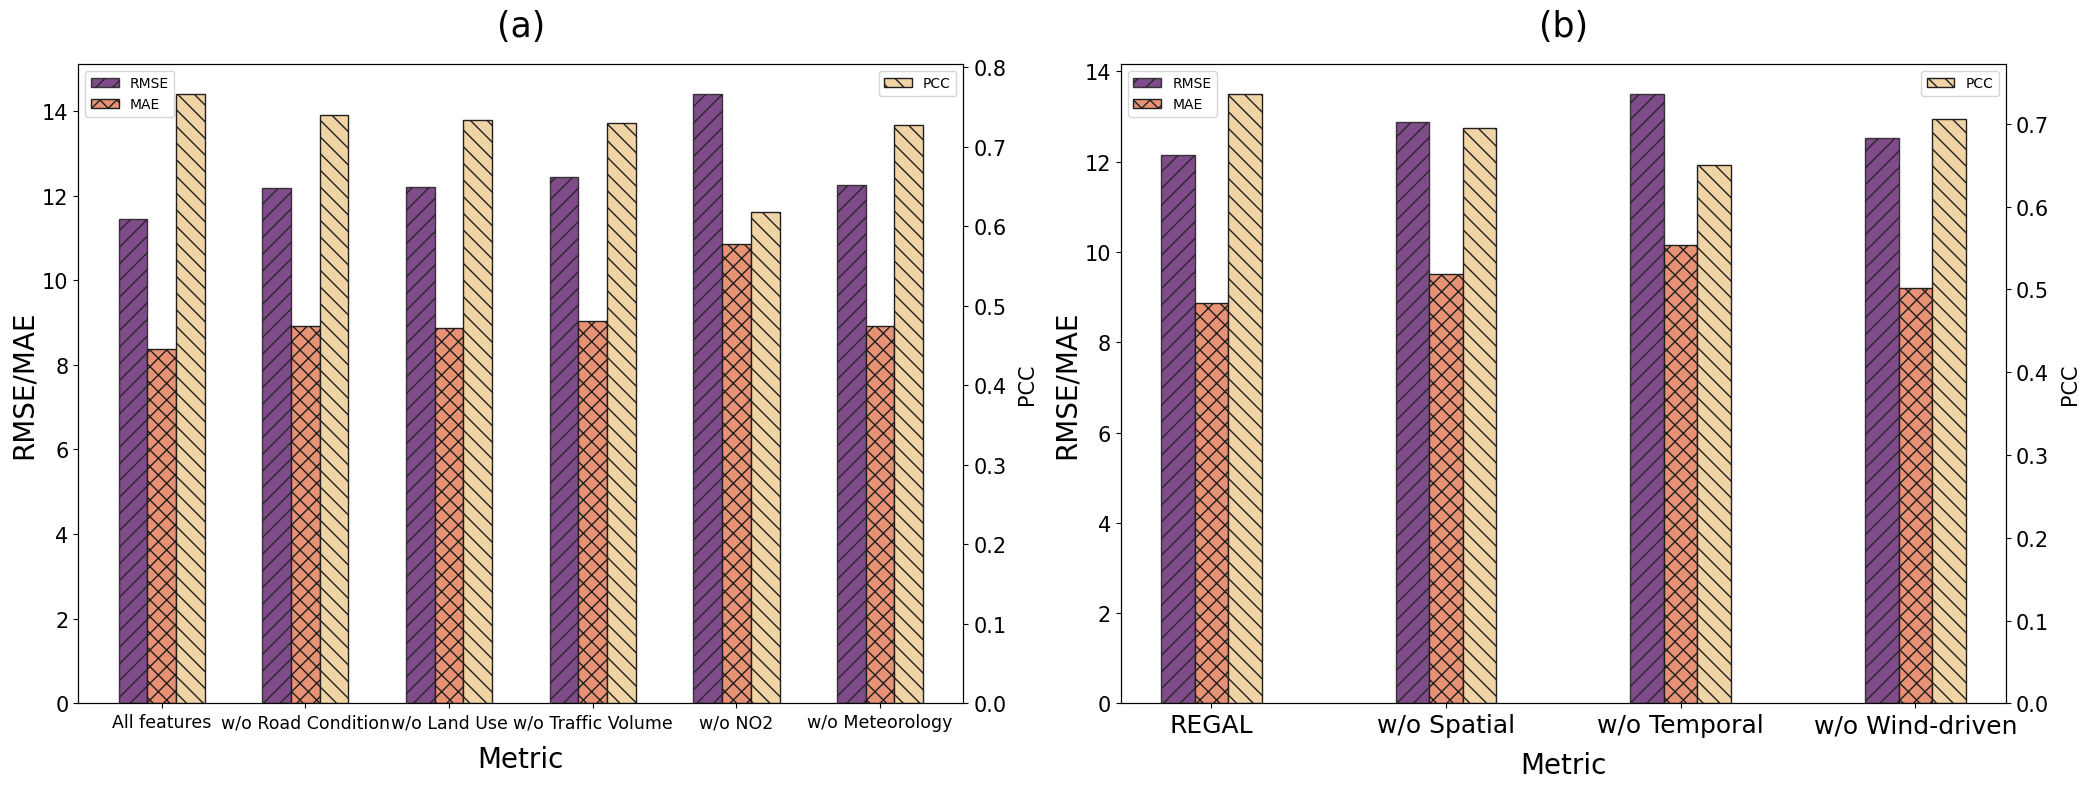

In [26]:
# First set of bars
feat_categories = ["All features"] + [value[-1] for value in ablation_feat_dict.values()]
n_feat_categories = len(feat_categories)
x = np.arange(n_feat_categories) * 0.7  # Increase the spacing between categories

# Second set of bars
component_categories = ["REGAL"] + [value[-1] for value in ablation_component_dict.values()]
n_com_categories = len(component_categories)
x2 = np.arange(n_com_categories) * 0.7  # Increase the spacing between categories

# Create a figure with two subplots side by side
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(21, 8))

# First subplot
bar_width_f = 0.14
bar_space_f = 0.14
bars1 = ax1.bar(x - bar_width_f, feat_RMSE_list, bar_space_f, label='RMSE', hatch='//', edgecolor='#1f1f1f', color='#692c75', alpha=0.85)
bars2 = ax1.bar(x, feat_MAE_list, bar_space_f, label='MAE', hatch='xx', edgecolor='#1f1f1f', color='#e89275', alpha=1)
ax1.set_xlabel('Metric', fontsize=20, labelpad=10)
ax1.set_ylabel('RMSE/MAE', fontsize=20, labelpad=3)
ax1.set_xticks(x)
ax1.set_xticklabels(feat_categories, rotation=0, ha='center', fontsize=12.5)

ax1.tick_params(axis='y', labelsize=15)
# Add subplot title (a)
ax1.set_title('(a)', fontsize=25, loc='center', pad=20)

ax2 = ax1.twinx()
bars3 = ax2.bar(x + bar_width_f, feat_PCC_list, bar_space_f, label='PCC', hatch='\\\\', edgecolor='#1f1f1f', color='#f1d4a5', alpha=1)
ax2.set_ylabel('PCC', fontsize=15, labelpad=8)
ax2.tick_params(axis='y', labelsize=15)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Second subplot
bar_width_c = 0.1
bar_space_c = 0.1
bars1 = ax3.bar(x2 - bar_width_c, component_RMSE_list, bar_space_c, label='RMSE', hatch='//', edgecolor='#1f1f1f', color='#692c75', alpha=0.85)
bars2 = ax3.bar(x2, component_MAE_list, bar_space_c, label='MAE', hatch='xx', edgecolor='#1f1f1f', color='#e89275', alpha=1)
ax3.set_xlabel('Metric', fontsize=20, labelpad=10)
ax3.set_ylabel('RMSE/MAE', fontsize=20, labelpad=3)
ax3.set_xticks(x2)
ax3.set_xticklabels(component_categories, rotation=0, ha='center', fontsize=18)
ax3.tick_params(axis='y', labelsize=15)
# Add subplot title (b)
ax3.set_title('(b)', fontsize=25, loc='center', pad=20)

ax4 = ax3.twinx()
bars3 = ax4.bar(x2 + bar_width_c, component_PCC_list, bar_space_c, label='PCC', hatch='\\\\', edgecolor='#1f1f1f', color='#f1d4a5', alpha=1)
ax4.set_ylabel('PCC', fontsize=15, labelpad=8)
ax4.tick_params(axis='y', labelsize=15)

ax3.legend(loc='upper left')
ax4.legend(loc='upper right')
plt.savefig(f'./Results/Ablation/Ablation_results.png')
# Adjust layout and show the plot
plt.tight_layout()
plt.show()